In [1]:
import os, random, warnings, time
#warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from IPython.display import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go

print ("Random number with seed 73")
random.seed(73)

os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'

Random number with seed 73


In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

#from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [3]:
from qb2_train_libs import *

Random number with seed 73


In [4]:
!nvidia-smi

Tue Sep 19 13:58:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.34                 Driver Version: 537.34       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   66C    P0              49W / 215W |    518MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 0. No Cholesky - No Partial Trace

In [5]:
base_name = 'pe_e4_50a50b'

rs_df = pd.read_csv('./datasets/2qb_random_state_50A_50B.csv')

#Se calcula la cantidad de datos para train, val y test, siguiendo regla 70/20/10 respectivamente
trn_data_count = int(len(rs_df)*0.7)
val_data_count = int(len(rs_df)*0.2)
tst_data_count = int(len(rs_df)*0.1)
trn_data_count, val_data_count, tst_data_count

(700, 200, 100)

In [6]:
Xs = rs_df[rs_df.columns[2:-2]]
Ys = rs_df[rs_df.columns[-2:-1]]

#Se particionan los dataframes según proporción train/val/test y
#convierten a arreglos numpy para alimentación de modelo
x_train = Xs[:trn_data_count].to_numpy().astype('float32')
y_train = Ys[:trn_data_count].to_numpy().astype('float32')

x_val = Xs[trn_data_count:trn_data_count+val_data_count].to_numpy().astype('float32')
y_val = Ys[trn_data_count:trn_data_count+val_data_count].to_numpy().astype('float32')

x_tst = Xs[trn_data_count+val_data_count:].to_numpy().astype('float32')
y_tst = Ys[trn_data_count+val_data_count:].to_numpy().astype('float32')
#Se verifica tamaños para garantizar dimensiones compatibles
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_tst.shape, y_tst.shape)
print(Xs.shape[0], (x_train.shape[0]+x_val.shape[0]+x_tst.shape[0]))

(700, 16) (700, 1) (200, 16) (200, 1) (100, 16) (100, 1)
1000 1000


## 0.1. ReLu intermedia

### 0.1.1. Model 2

Experiment:  1, optimizer: adam, bs:  2, lr:    1.0E-03

Epoch 1/100
350/350 [==============================] - 5s 7ms/step - loss: 0.1078 - mse: 0.1078 - val_loss: 0.0705 - val_mse: 0.0705

Epoch 00001: loss improved from inf to 0.08930, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_1.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0296 - val_mse: 0.0296

Epoch 00002: loss improved from 0.08930 to 0.04795, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_1.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0151 - val_mse: 0.0151

Epoch 00003: loss improved from 0.04795 to 0.02219, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_1.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0108 - val_mse: 0.0108

Epoch 00004: loss improv

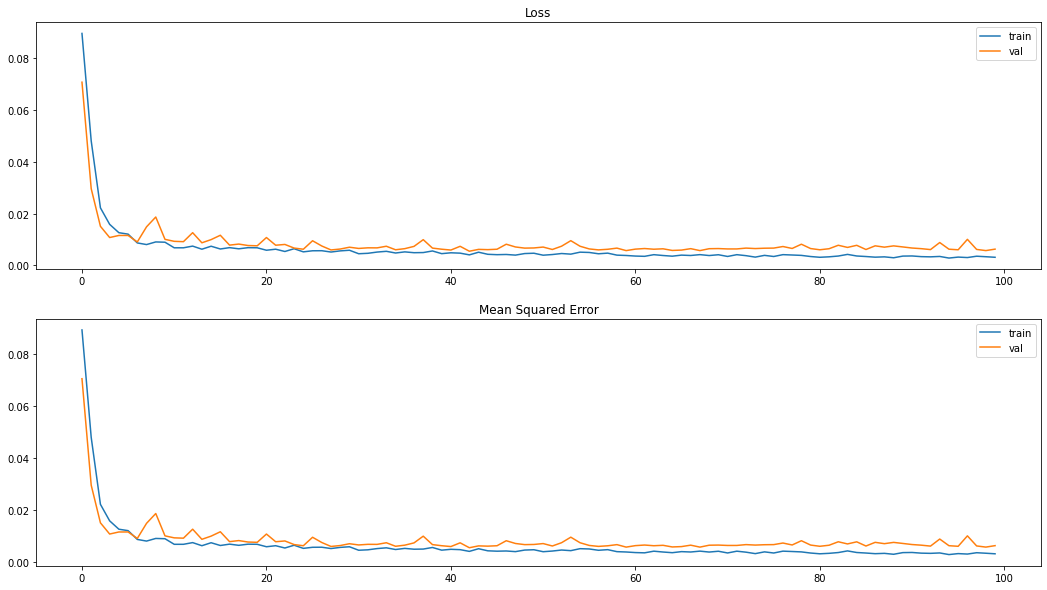

Experiment:  2, optimizer: adam, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 3s 6ms/step - loss: 0.1432 - mse: 0.1432 - val_loss: 0.0790 - val_mse: 0.0790

Epoch 00001: loss improved from inf to 0.10775, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_2.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0799 - mse: 0.0799 - val_loss: 0.0757 - val_mse: 0.0757

Epoch 00002: loss improved from 0.10775 to 0.08002, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_2.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0766 - mse: 0.0766 - val_loss: 0.0715 - val_mse: 0.0715

Epoch 00003: loss improved from 0.08002 to 0.07641, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_2.h5
Epoch 4/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0650 - val_mse: 0.0650

Epoch 00004: loss improve

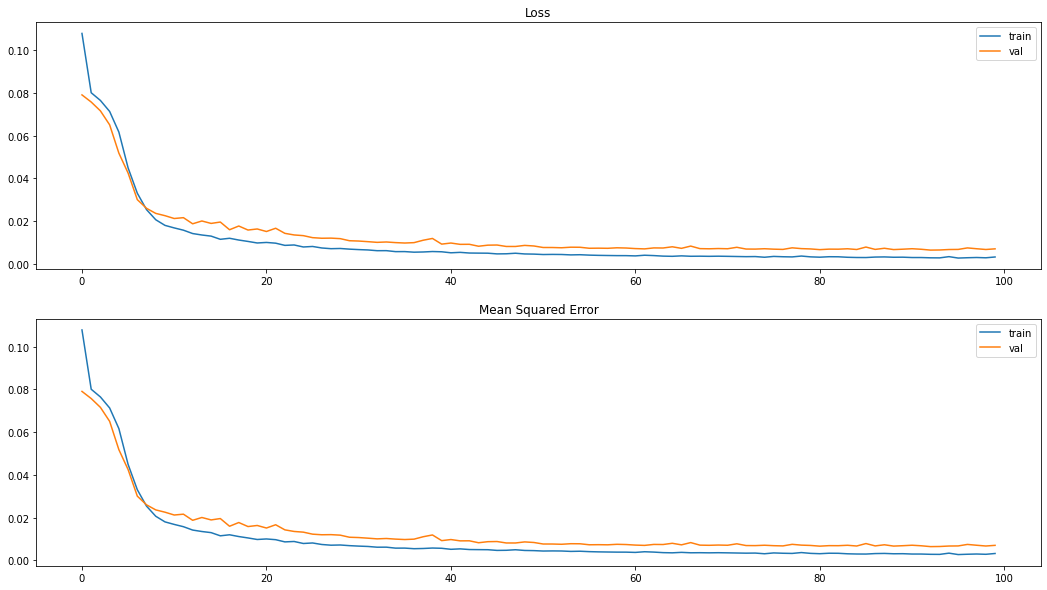

Experiment:  3, optimizer: adam, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 1s 6ms/step - loss: 0.1017 - mse: 0.1017 - val_loss: 0.0685 - val_mse: 0.0685

Epoch 00001: loss improved from inf to 0.08507, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_3.h5
Epoch 2/100
175/175 [==============================] - 1s 5ms/step - loss: 0.0546 - mse: 0.0546 - val_loss: 0.0289 - val_mse: 0.0289

Epoch 00002: loss improved from 0.08507 to 0.04212, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_3.h5
Epoch 3/100
175/175 [==============================] - 1s 5ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0216 - val_mse: 0.0216

Epoch 00003: loss improved from 0.04212 to 0.02349, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_3.h5
Epoch 4/100
175/175 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0165 - val_mse: 0.0165

Epoch 00004: loss improve

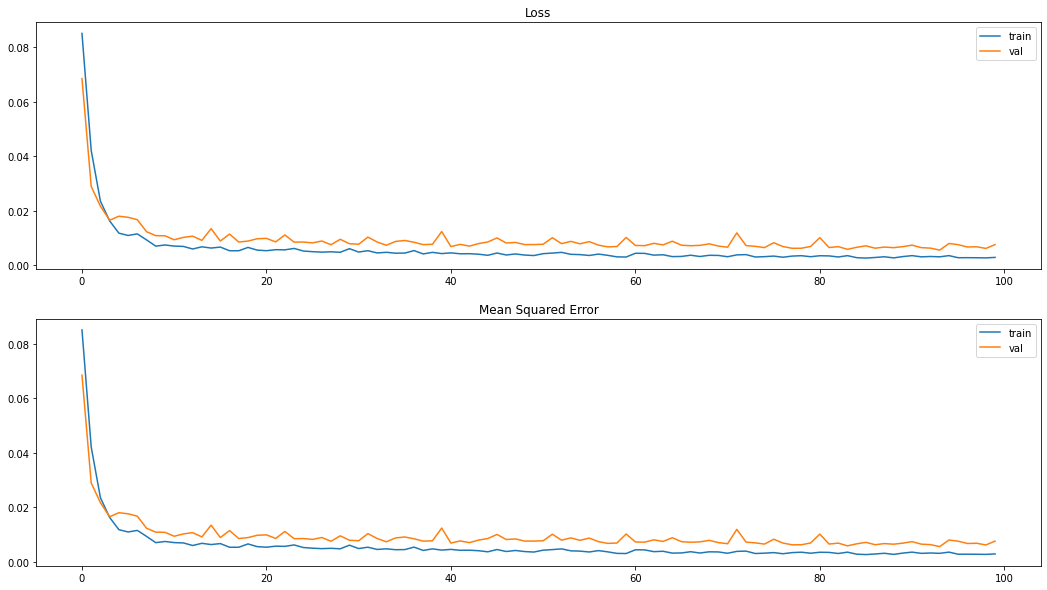

Experiment:  4, optimizer: adam, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.1786 - mse: 0.1786 - val_loss: 0.0802 - val_mse: 0.0802

Epoch 00001: loss improved from inf to 0.13150, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_4.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0798 - mse: 0.0798 - val_loss: 0.0792 - val_mse: 0.0792

Epoch 00002: loss improved from 0.13150 to 0.08067, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_4.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0772 - mse: 0.0772 - val_loss: 0.0759 - val_mse: 0.0759

Epoch 00003: loss improved from 0.08067 to 0.07720, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_4.h5
Epoch 4/100
175/175 [==============================] - 1s 5ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 0.0731 - val_mse: 0.0731

Epoch 00004: loss improve

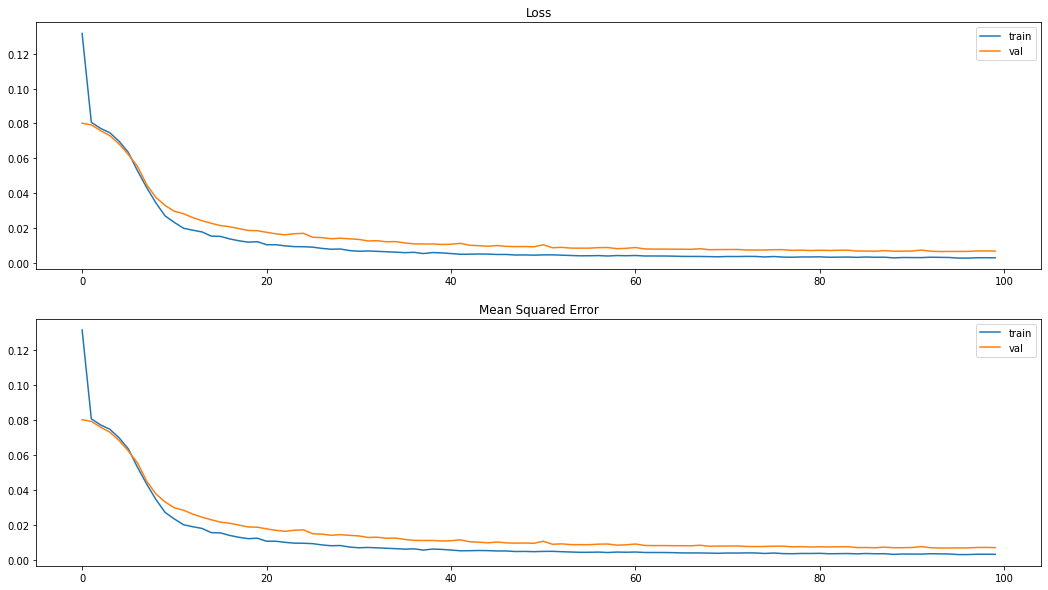

Experiment:  5, optimizer: adam, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1075 - mse: 0.1075 - val_loss: 0.0693 - val_mse: 0.0693

Epoch 00001: loss improved from inf to 0.08734, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_5.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0608 - mse: 0.0608 - val_loss: 0.0371 - val_mse: 0.0371

Epoch 00002: loss improved from 0.08734 to 0.05212, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_5.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0269 - val_mse: 0.0269

Epoch 00003: loss improved from 0.05212 to 0.02385, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_5.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0220 - val_mse: 0.0220

Epoch 00004: loss improved from 0

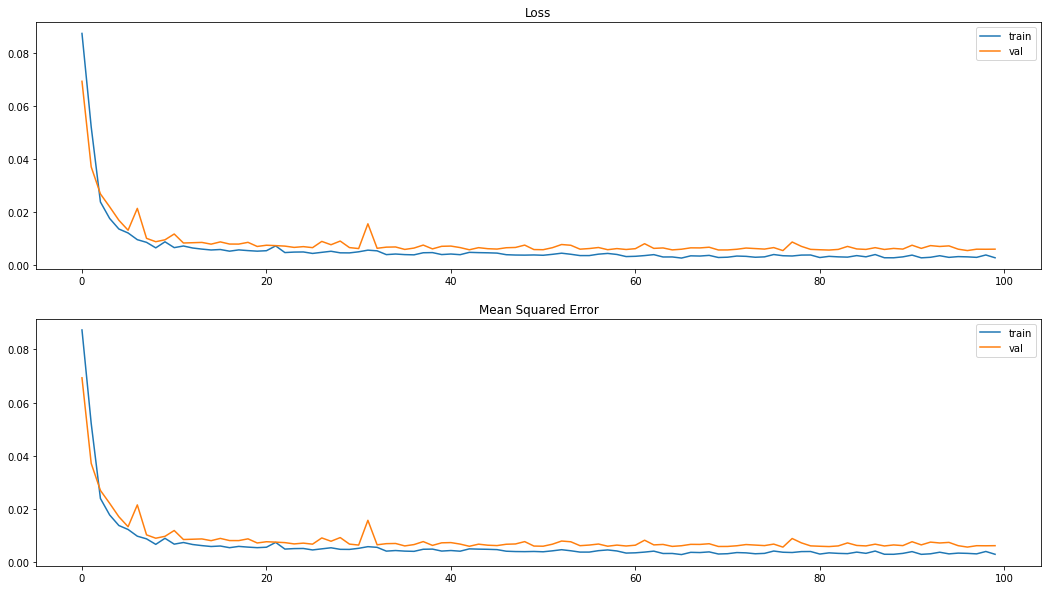

Experiment:  6, optimizer: adam, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1835 - mse: 0.1835 - val_loss: 0.1118 - val_mse: 0.1118

Epoch 00001: loss improved from inf to 0.17043, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_6.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0968 - mse: 0.0968 - val_loss: 0.0802 - val_mse: 0.0802

Epoch 00002: loss improved from 0.17043 to 0.08884, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_6.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0831 - mse: 0.0831 - val_loss: 0.0788 - val_mse: 0.0788

Epoch 00003: loss improved from 0.08884 to 0.08135, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_6.h5
Epoch 4/100
88/88 [==============================] - 1s 6ms/step - loss: 0.0896 - mse: 0.0896 - val_loss: 0.0775 - val_mse: 0.0775

Epoch 00004: loss improved from 0

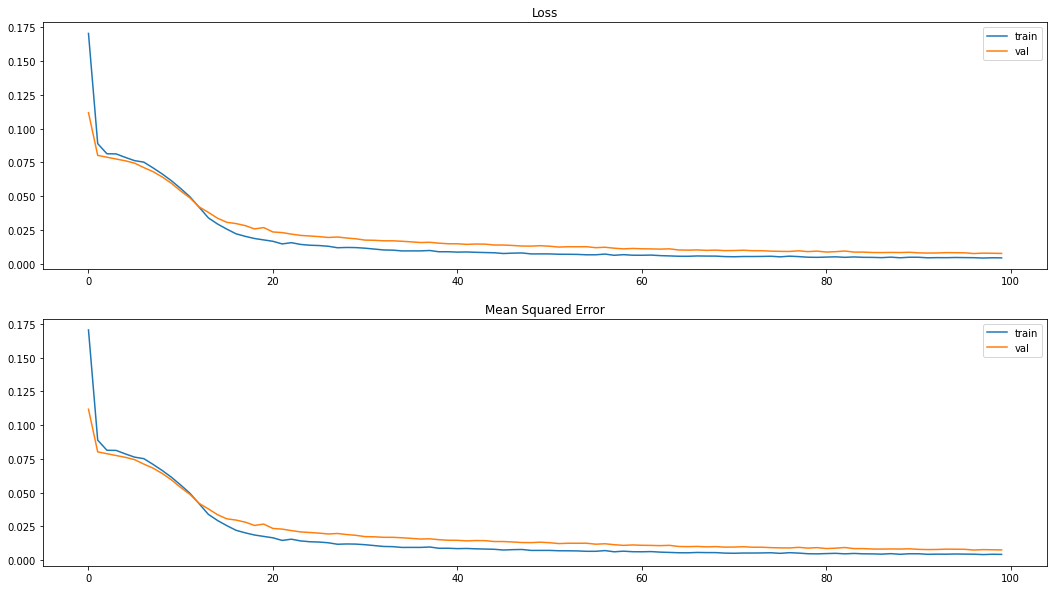

Experiment:  7, optimizer: adamax, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 3s 7ms/step - loss: 0.1295 - mse: 0.1295 - val_loss: 0.0794 - val_mse: 0.0794

Epoch 00001: loss improved from inf to 0.09804, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_7.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0789 - mse: 0.0789 - val_loss: 0.0723 - val_mse: 0.0723

Epoch 00002: loss improved from 0.09804 to 0.08110, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_7.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0684 - mse: 0.0684 - val_loss: 0.0540 - val_mse: 0.0540

Epoch 00003: loss improved from 0.08110 to 0.06581, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_7.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0333 - val_mse: 0.0333

Epoch 00004: loss impro

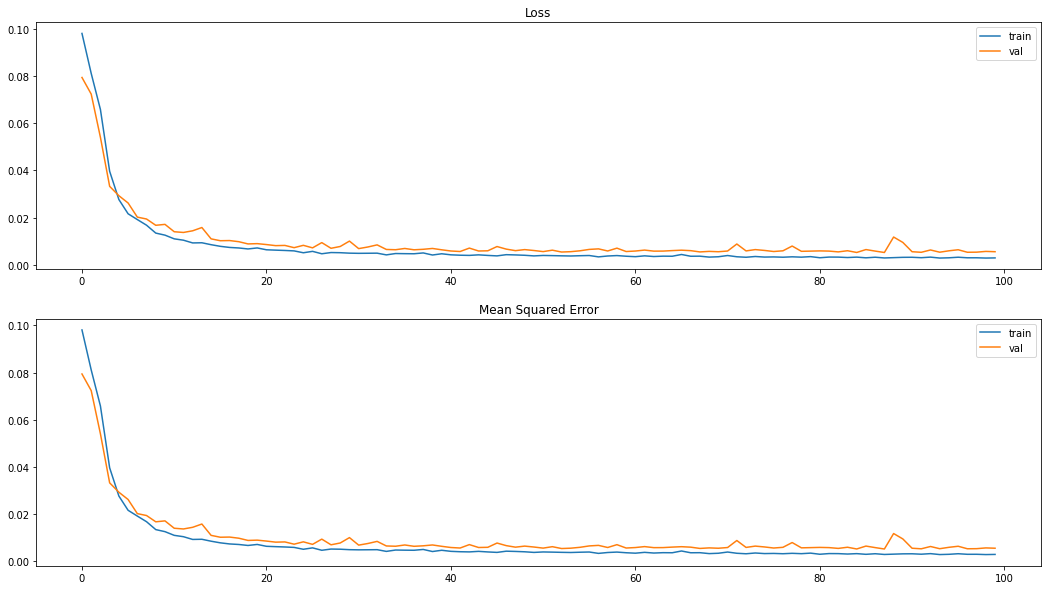

Experiment:  8, optimizer: adamax, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 3s 7ms/step - loss: 0.1828 - mse: 0.1828 - val_loss: 0.1003 - val_mse: 0.1003

Epoch 00001: loss improved from inf to 0.15625, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_8.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.1021 - mse: 0.1021 - val_loss: 0.0810 - val_mse: 0.0810

Epoch 00002: loss improved from 0.15625 to 0.09057, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_8.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0806 - val_mse: 0.0806

Epoch 00003: loss improved from 0.09057 to 0.08379, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_8.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 0.0806 - val_mse: 0.0806

Epoch 00004: loss impro

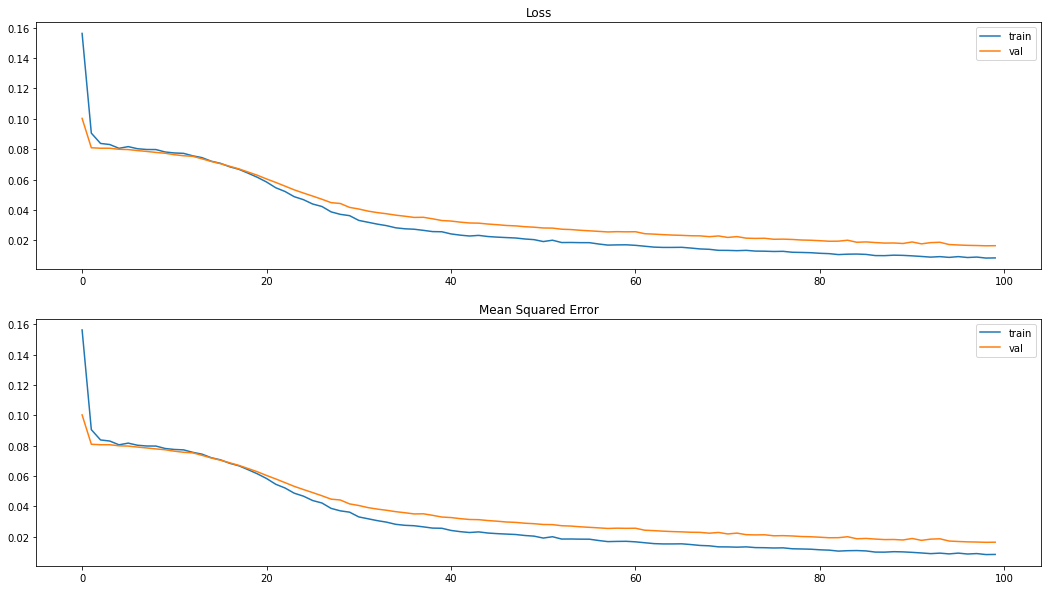

Experiment:  9, optimizer: adamax, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.1084 - mse: 0.1084 - val_loss: 0.0844 - val_mse: 0.0844

Epoch 00001: loss improved from inf to 0.09195, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_9.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0778 - mse: 0.0778 - val_loss: 0.0701 - val_mse: 0.0701

Epoch 00002: loss improved from 0.09195 to 0.07889, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_9.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0730 - mse: 0.0730 - val_loss: 0.0524 - val_mse: 0.0524

Epoch 00003: loss improved from 0.07889 to 0.06610, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_9.h5
Epoch 4/100
175/175 [==============================] - 1s 7ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0365 - val_mse: 0.0365

Epoch 00004: loss impro

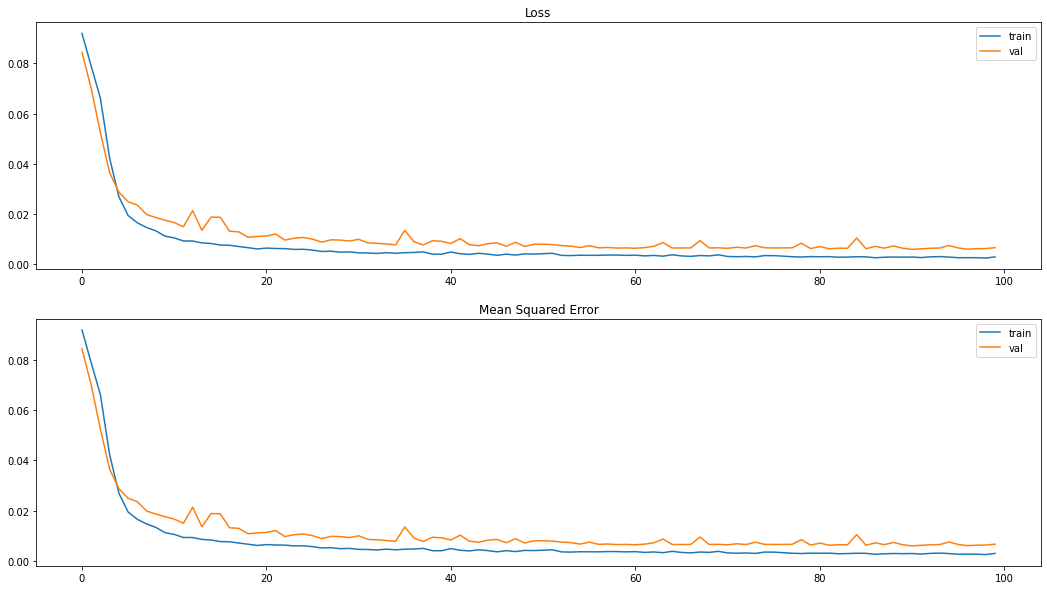

Experiment: 10, optimizer: adamax, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.2039 - mse: 0.2039 - val_loss: 0.1263 - val_mse: 0.1263

Epoch 00001: loss improved from inf to 0.17296, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_10.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.1205 - mse: 0.1205 - val_loss: 0.0828 - val_mse: 0.0828

Epoch 00002: loss improved from 0.17296 to 0.10594, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_10.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0861 - mse: 0.0861 - val_loss: 0.0810 - val_mse: 0.0810

Epoch 00003: loss improved from 0.10594 to 0.08398, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_10.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0806 - mse: 0.0806 - val_loss: 0.0810 - val_mse: 0.0810

Epoch 00004: loss im

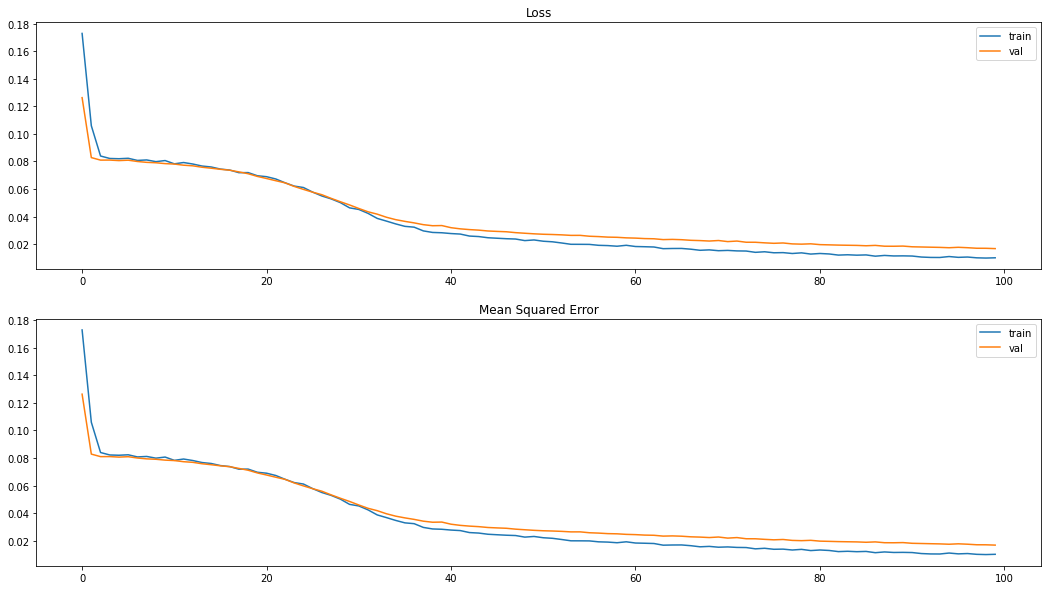

Experiment: 11, optimizer: adamax, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1084 - mse: 0.1084 - val_loss: 0.0809 - val_mse: 0.0809

Epoch 00001: loss improved from inf to 0.09289, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_11.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0810 - mse: 0.0810 - val_loss: 0.0776 - val_mse: 0.0776

Epoch 00002: loss improved from 0.09289 to 0.07981, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_11.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0752 - mse: 0.0752 - val_loss: 0.0692 - val_mse: 0.0692

Epoch 00003: loss improved from 0.07981 to 0.07514, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_11.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0591 - val_mse: 0.0591

Epoch 00004: loss improved f

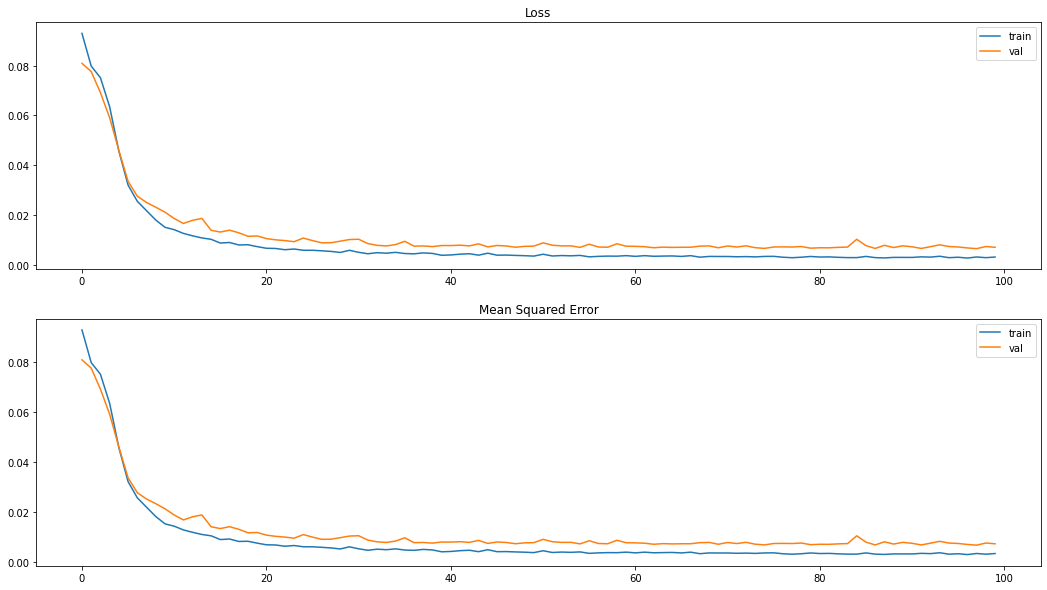

Experiment: 12, optimizer: adamax, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1920 - mse: 0.1920 - val_loss: 0.1592 - val_mse: 0.1592

Epoch 00001: loss improved from inf to 0.18848, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_12.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.1526 - mse: 0.1526 - val_loss: 0.1203 - val_mse: 0.1203

Epoch 00002: loss improved from 0.18848 to 0.15041, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_12.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.1268 - mse: 0.1268 - val_loss: 0.0923 - val_mse: 0.0923

Epoch 00003: loss improved from 0.15041 to 0.11255, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_12.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0948 - mse: 0.0948 - val_loss: 0.0821 - val_mse: 0.0821

Epoch 00004: loss improved f

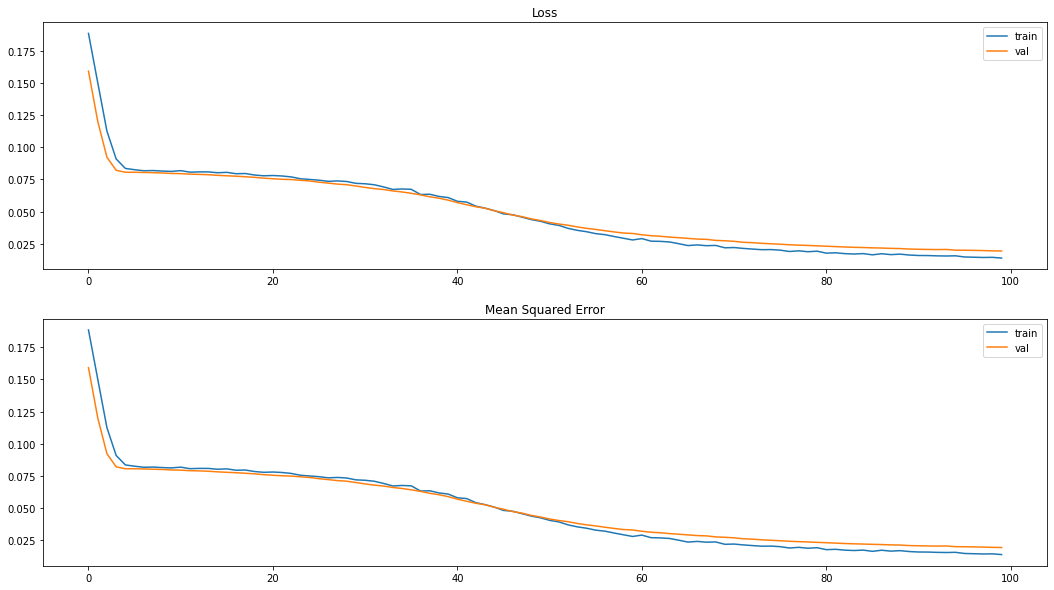

Experiment: 13, optimizer: nadam, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 6s 17ms/step - loss: 0.0987 - mse: 0.0987 - val_loss: 0.0652 - val_mse: 0.0652

Epoch 00001: loss improved from inf to 0.08589, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_13.h5
Epoch 2/100
350/350 [==============================] - 6s 16ms/step - loss: 0.0513 - mse: 0.0513 - val_loss: 0.0416 - val_mse: 0.0416

Epoch 00002: loss improved from 0.08589 to 0.04349, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_13.h5
Epoch 3/100
350/350 [==============================] - 5s 16ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0154 - val_mse: 0.0154

Epoch 00003: loss improved from 0.04349 to 0.01834, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_13.h5
Epoch 4/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0134 - val_mse: 0.0134

Epoch 00004: loss

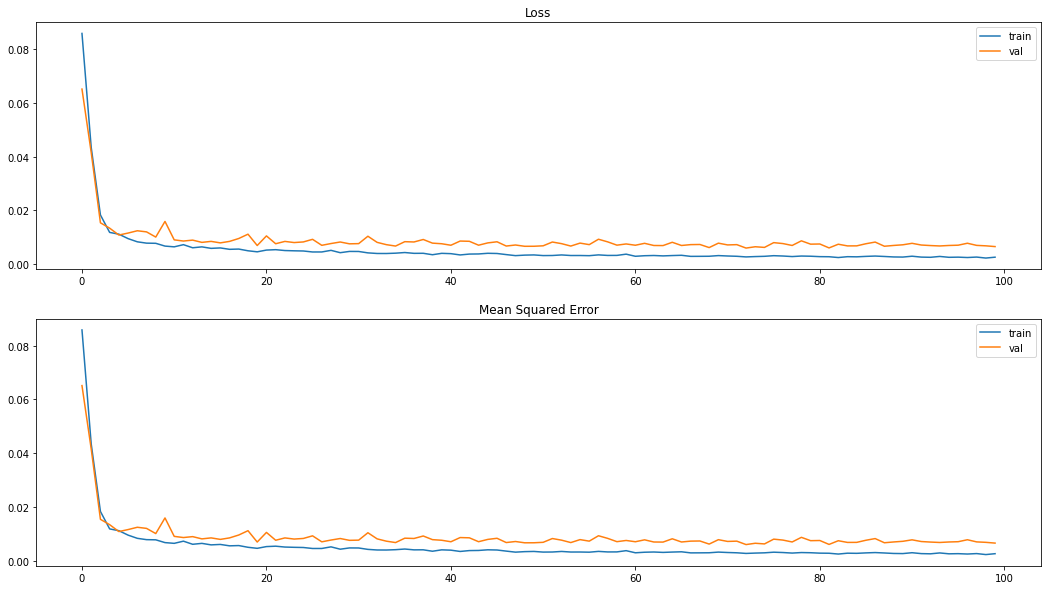

Experiment: 14, optimizer: nadam, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 6s 15ms/step - loss: 0.1605 - mse: 0.1605 - val_loss: 0.0803 - val_mse: 0.0803

Epoch 00001: loss improved from inf to 0.11463, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_14.h5
Epoch 2/100
350/350 [==============================] - 5s 14ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.0794 - val_mse: 0.0794

Epoch 00002: loss improved from 0.11463 to 0.08218, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_14.h5
Epoch 3/100
350/350 [==============================] - 5s 14ms/step - loss: 0.0787 - mse: 0.0787 - val_loss: 0.0759 - val_mse: 0.0759

Epoch 00003: loss improved from 0.08218 to 0.07896, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_14.h5
Epoch 4/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0790 - mse: 0.0790 - val_loss: 0.0710 - val_mse: 0.0710

Epoch 00004: loss

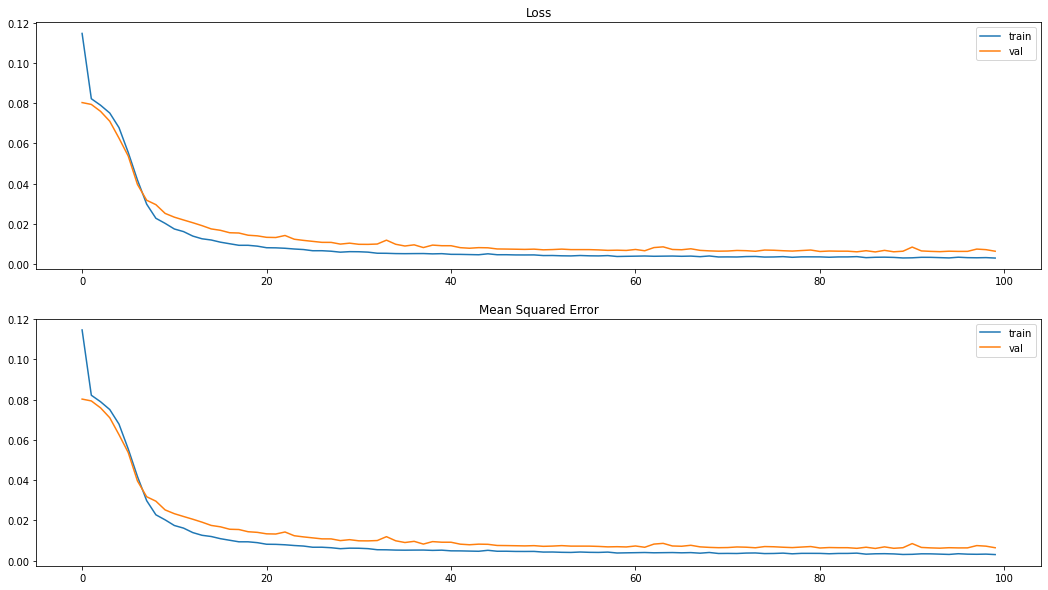

Experiment: 15, optimizer: nadam, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 4s 16ms/step - loss: 0.1058 - mse: 0.1058 - val_loss: 0.0604 - val_mse: 0.0604

Epoch 00001: loss improved from inf to 0.08526, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_15.h5
Epoch 2/100
175/175 [==============================] - 3s 16ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0274 - val_mse: 0.0274

Epoch 00002: loss improved from 0.08526 to 0.04022, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_15.h5
Epoch 3/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0228 - val_mse: 0.0228

Epoch 00003: loss improved from 0.04022 to 0.02007, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_15.h5
Epoch 4/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0234 - val_mse: 0.0234

Epoch 00004: loss

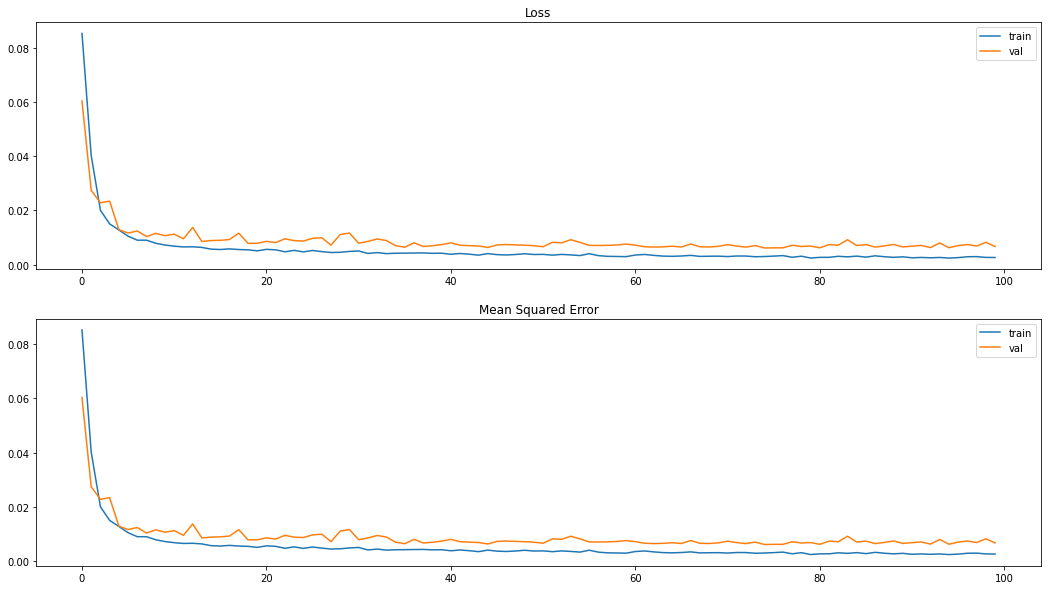

Experiment: 16, optimizer: nadam, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 3s 16ms/step - loss: 0.1621 - mse: 0.1621 - val_loss: 0.0808 - val_mse: 0.0808

Epoch 00001: loss improved from inf to 0.12648, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_16.h5
Epoch 2/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0849 - mse: 0.0849 - val_loss: 0.0788 - val_mse: 0.0788

Epoch 00002: loss improved from 0.12648 to 0.08098, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_16.h5
Epoch 3/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0762 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0761

Epoch 00003: loss improved from 0.08098 to 0.07885, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_16.h5
Epoch 4/100
175/175 [==============================] - 3s 16ms/step - loss: 0.0781 - mse: 0.0781 - val_loss: 0.0723 - val_mse: 0.0723

Epoch 00004: loss

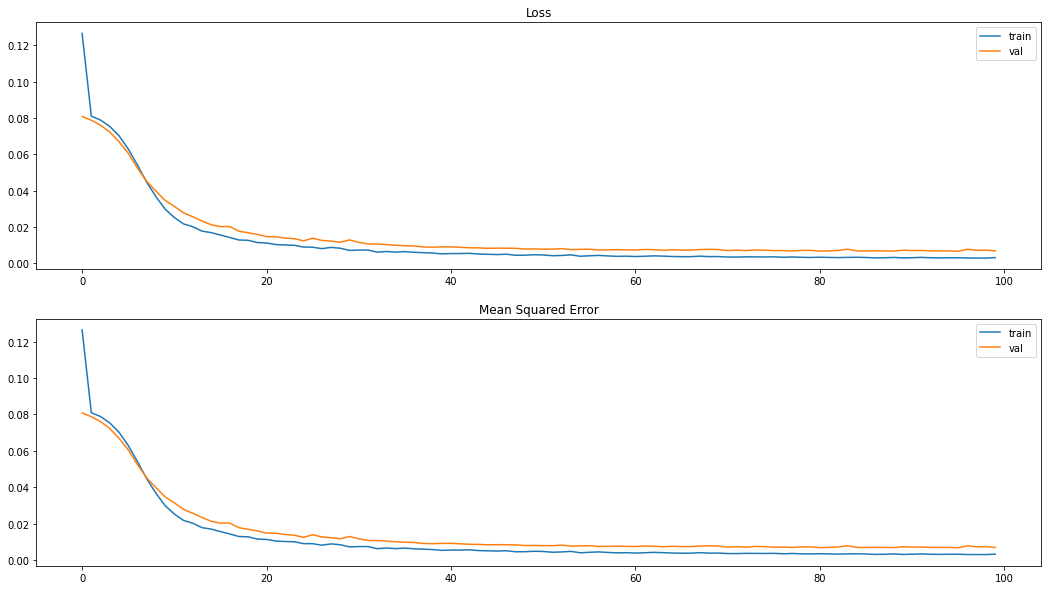

Experiment: 17, optimizer: nadam, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 2s 17ms/step - loss: 0.1179 - mse: 0.1179 - val_loss: 0.0704 - val_mse: 0.0704

Epoch 00001: loss improved from inf to 0.09164, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_17.h5
Epoch 2/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0656 - mse: 0.0656 - val_loss: 0.0376 - val_mse: 0.0376

Epoch 00002: loss improved from 0.09164 to 0.05571, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_17.h5
Epoch 3/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0216 - val_mse: 0.0216

Epoch 00003: loss improved from 0.05571 to 0.02878, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_17.h5
Epoch 4/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0191 - val_mse: 0.0191

Epoch 00004: loss improve

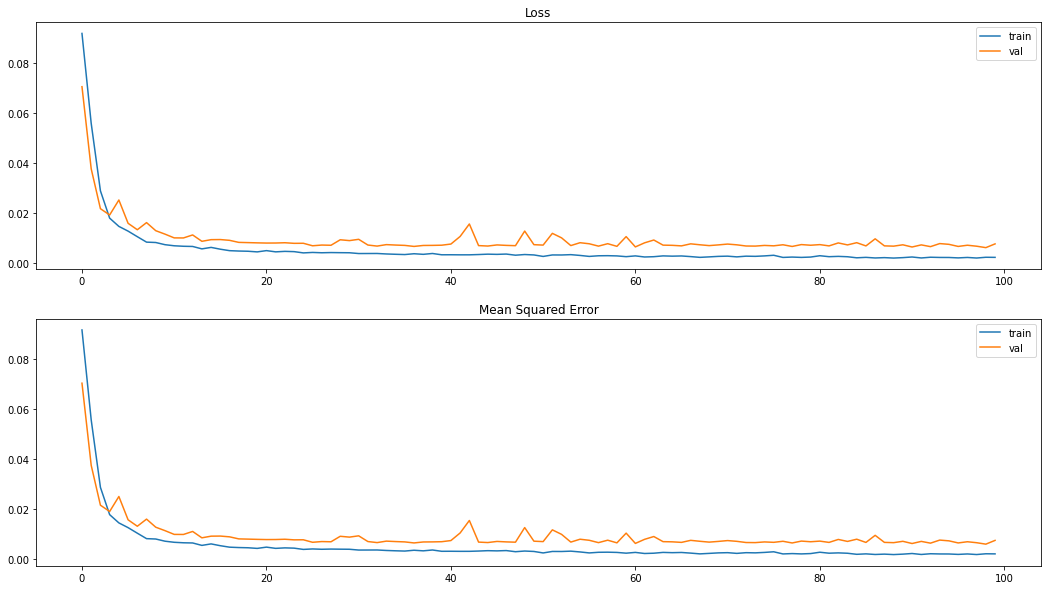

Experiment: 18, optimizer: nadam, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 2s 17ms/step - loss: 0.1772 - mse: 0.1772 - val_loss: 0.0942 - val_mse: 0.0942

Epoch 00001: loss improved from inf to 0.16075, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_18.h5
Epoch 2/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0912 - mse: 0.0912 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00002: loss improved from 0.16075 to 0.08489, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_18.h5
Epoch 3/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0907 - mse: 0.0907 - val_loss: 0.0793 - val_mse: 0.0793

Epoch 00003: loss improved from 0.08489 to 0.08198, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m2_multiopt_18.h5
Epoch 4/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0778 - val_mse: 0.0778

Epoch 00004: loss improve

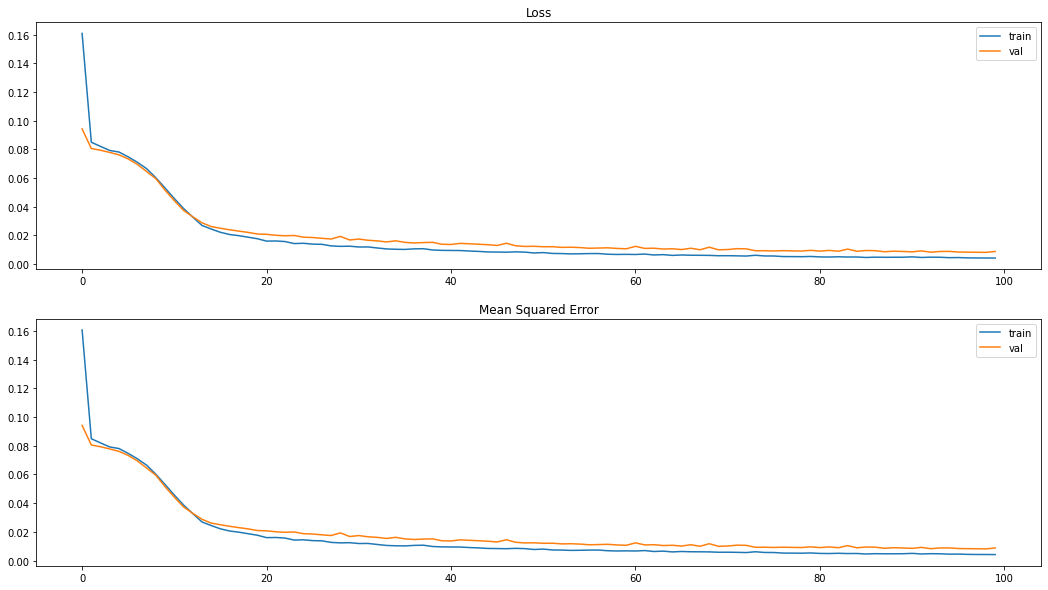

Total elapsed training time was: 3390.0887763500 seconds
Total elapsed training time was:  0.9416913267638948  hours


In [7]:
results_df = train_explore_model(exp_name= base_name+'_irelu_m2_multiopt', n_epochs=100, model_sel=2,
                                 in_dim_s = x_train.shape[1], in_act = 'relu', out_act = None,
                                 x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_tst=x_tst, y_tst=y_tst)

In [8]:
results_df

exp_name exp_number optimizer b_s      lr  trn_loss  \
0   pe_e4_50a50b_irelu_m2_multiopt         10    adamax   4  0.0010  0.002469   
1   pe_e4_50a50b_irelu_m2_multiopt         18     nadam   8  0.0010  0.001932   
2   pe_e4_50a50b_irelu_m2_multiopt         14     nadam   2  0.0010  0.002292   
3   pe_e4_50a50b_irelu_m2_multiopt          4      adam   4  0.0010  0.002621   
4   pe_e4_50a50b_irelu_m2_multiopt          8    adamax   2  0.0010  0.002867   
5   pe_e4_50a50b_irelu_m2_multiopt         15     nadam   2  0.0001  0.003019   
6   pe_e4_50a50b_irelu_m2_multiopt          6      adam   8  0.0010  0.002711   
7   pe_e4_50a50b_irelu_m2_multiopt          3      adam   2  0.0001  0.002724   
8   pe_e4_50a50b_irelu_m2_multiopt          7      adam   8  0.0001  0.004136   
9   pe_e4_50a50b_irelu_m2_multiopt         17     nadam   4  0.0001  0.002975   
10  pe_e4_50a50b_irelu_m2_multiopt          5      adam   4  0.0001  0.003048   
11  pe_e4_50a50b_irelu_m2_multiopt          2      adam   2  0.0010  0.002862   
12  pe_e4_50a50b_irelu_m2_multiopt         16     nadam   4  0.0010  0.002460   
13  pe_e4_50a50b_irelu_m2_multiopt         19     nadam   8  0.0001  0.004140   
14  pe_e4_50a50b_irelu_m2_multiopt         12    adamax   8  0.0010  0.002874   
15  pe_e4_50a50b_irelu_m2_multiopt          9    adamax   2  0.0001  0.008306   
16  pe_e4_50a50b_irelu_m2_multiopt         11    adamax   4  0.0001  0.009894   
17  pe_e4_50a50b_irelu_m2_multiopt         13    adamax   8  0.0001  0.013888   

     trn_mse  val_loss   val_mse   tst_mse  
0   0.002469  0.006269  0.006269  0.004398  
1   0.001932  0.006688  0.006688  0.004871  
2   0.002292  0.006843  0.006843  0.005042  
3   0.002621  0.007106  0.007106  0.005372  
4   0.002867  0.005685  0.005685  0.005401  
5   0.003019  0.006410  0.006410  0.005567  
6   0.002711  0.006042  0.006042  0.006014  
7   0.002724  0.006761  0.006761  0.006188  
8   0.004136  0.007797  0.007797  0.006275  
9   0.002975  0.007226  0.007226  0.006363  
10  0.003048  0.006837  0.006837  0.006496  
11  0.002862  0.006272  0.006272  0.006734  
12  0.002460  0.006271  0.006271  0.006791  
13  0.004140  0.008736  0.008736  0.007049  
14  0.002874  0.006927  0.006927  0.008822  
15  0.008306  0.016379  0.016379  0.012510  
16  0.009894  0.016984  0.016984  0.013761  
17  0.013888  0.019374  0.019374  0.018934

### 0.1.2. Model 3

Experiment:  1, optimizer: adam, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 3s 6ms/step - loss: 0.0913 - mse: 0.0913 - val_loss: 0.0565 - val_mse: 0.0565

Epoch 00001: loss improved from inf to 0.07856, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_1.h5
Epoch 2/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0250 - val_mse: 0.0250

Epoch 00002: loss improved from 0.07856 to 0.03358, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_1.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0188 - val_mse: 0.0188

Epoch 00003: loss improved from 0.03358 to 0.01755, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_1.h5
Epoch 4/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0192 - val_mse: 0.0192

Epoch 00004: loss improve

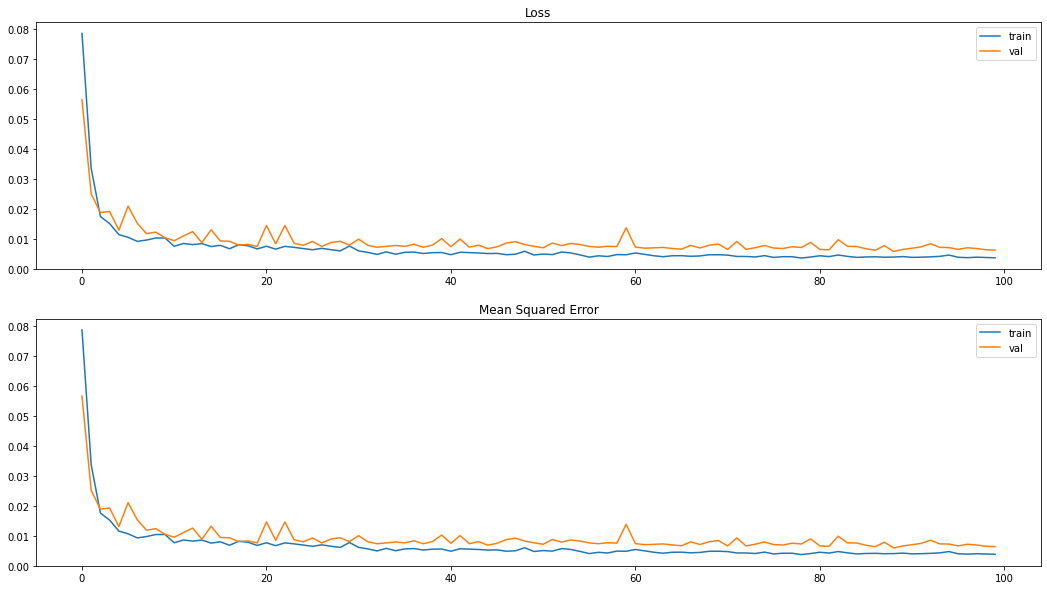

Experiment:  2, optimizer: adam, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 2s 6ms/step - loss: 0.1416 - mse: 0.1416 - val_loss: 0.0806 - val_mse: 0.0806

Epoch 00001: loss improved from inf to 0.11300, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_2.h5
Epoch 2/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0826 - mse: 0.0826 - val_loss: 0.0788 - val_mse: 0.0788

Epoch 00002: loss improved from 0.11300 to 0.08246, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_2.h5
Epoch 3/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0815 - mse: 0.0815 - val_loss: 0.0750 - val_mse: 0.0750

Epoch 00003: loss improved from 0.08246 to 0.07955, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_2.h5
Epoch 4/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0702 - mse: 0.0702 - val_loss: 0.0687 - val_mse: 0.0687

Epoch 00004: loss improve

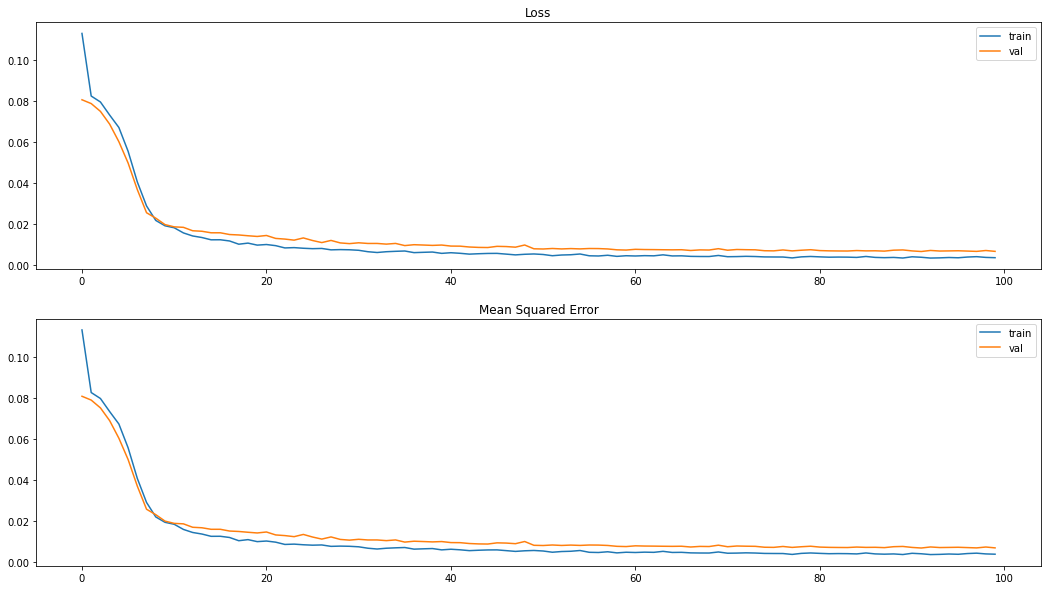

Experiment:  3, optimizer: adam, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.1093 - mse: 0.1093 - val_loss: 0.0840 - val_mse: 0.0840

Epoch 00001: loss improved from inf to 0.09120, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_3.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0757 - mse: 0.0757 - val_loss: 0.0465 - val_mse: 0.0465

Epoch 00002: loss improved from 0.09120 to 0.06563, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_3.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0269 - val_mse: 0.0269

Epoch 00003: loss improved from 0.06563 to 0.03375, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_3.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0226 - val_mse: 0.0226

Epoch 00004: loss improve

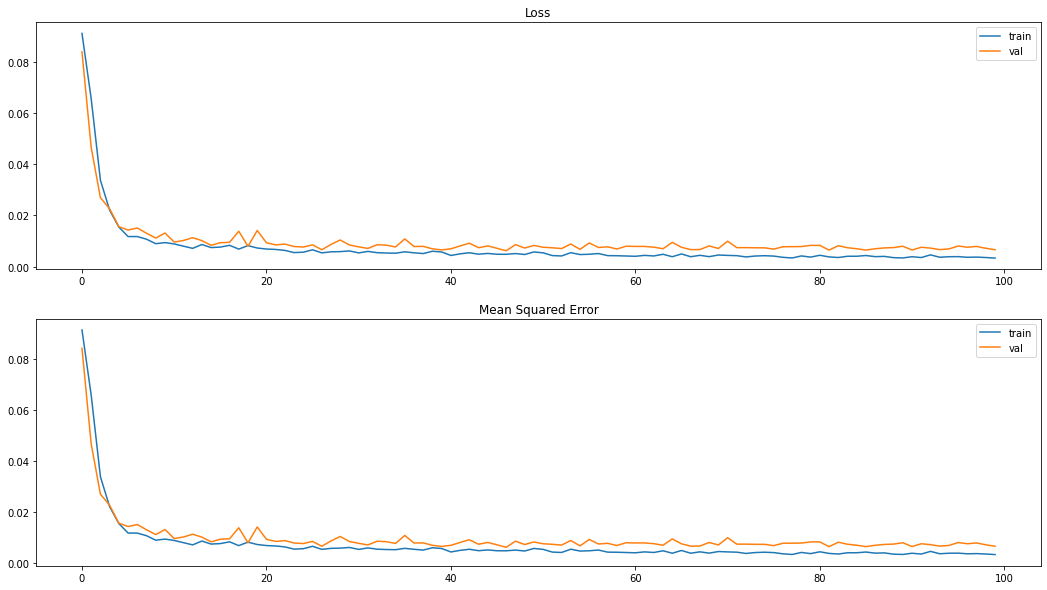

Experiment:  4, optimizer: adam, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 1s 7ms/step - loss: 0.1681 - mse: 0.1681 - val_loss: 0.0810 - val_mse: 0.0810

Epoch 00001: loss improved from inf to 0.14021, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_4.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0842 - mse: 0.0842 - val_loss: 0.0813 - val_mse: 0.0813

Epoch 00002: loss improved from 0.14021 to 0.08371, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_4.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0789 - mse: 0.0789 - val_loss: 0.0802 - val_mse: 0.0802

Epoch 00003: loss improved from 0.08371 to 0.08286, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_4.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0807 - mse: 0.0807 - val_loss: 0.0786 - val_mse: 0.0786

Epoch 00004: loss did not

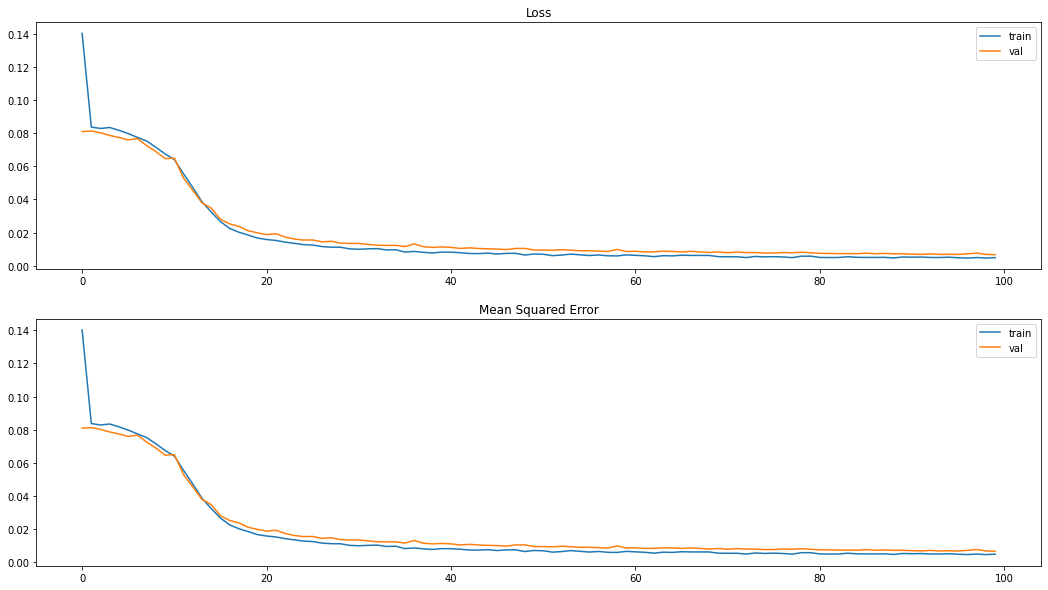

Experiment:  5, optimizer: adam, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1434 - mse: 0.1434 - val_loss: 0.0761 - val_mse: 0.0761

Epoch 00001: loss improved from inf to 0.10206, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_5.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0761 - mse: 0.0761 - val_loss: 0.0549 - val_mse: 0.0549

Epoch 00002: loss improved from 0.10206 to 0.07148, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_5.h5
Epoch 3/100
88/88 [==============================] - 1s 6ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0319 - val_mse: 0.0319

Epoch 00003: loss improved from 0.07148 to 0.04075, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_5.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0322 - val_mse: 0.0322

Epoch 00004: loss improved from 0

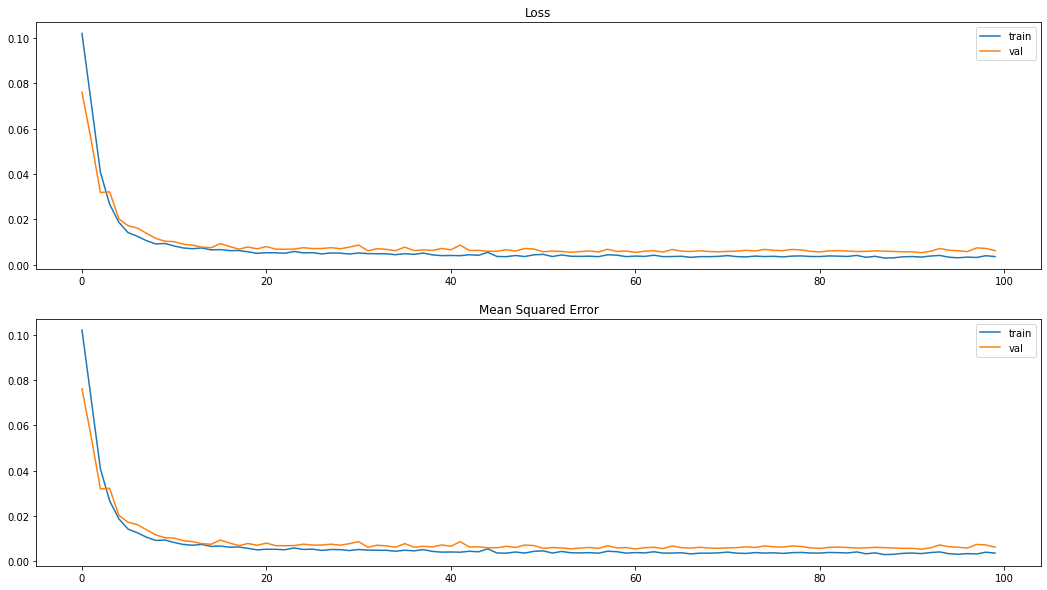

Experiment:  6, optimizer: adam, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1971 - mse: 0.1971 - val_loss: 0.1316 - val_mse: 0.1316

Epoch 00001: loss improved from inf to 0.17964, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_6.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.1173 - mse: 0.1173 - val_loss: 0.0811 - val_mse: 0.0811

Epoch 00002: loss improved from 0.17964 to 0.10250, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_6.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0863 - mse: 0.0863 - val_loss: 0.0815 - val_mse: 0.0815

Epoch 00003: loss improved from 0.10250 to 0.08171, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_6.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0819 - mse: 0.0819 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00004: loss did not improve

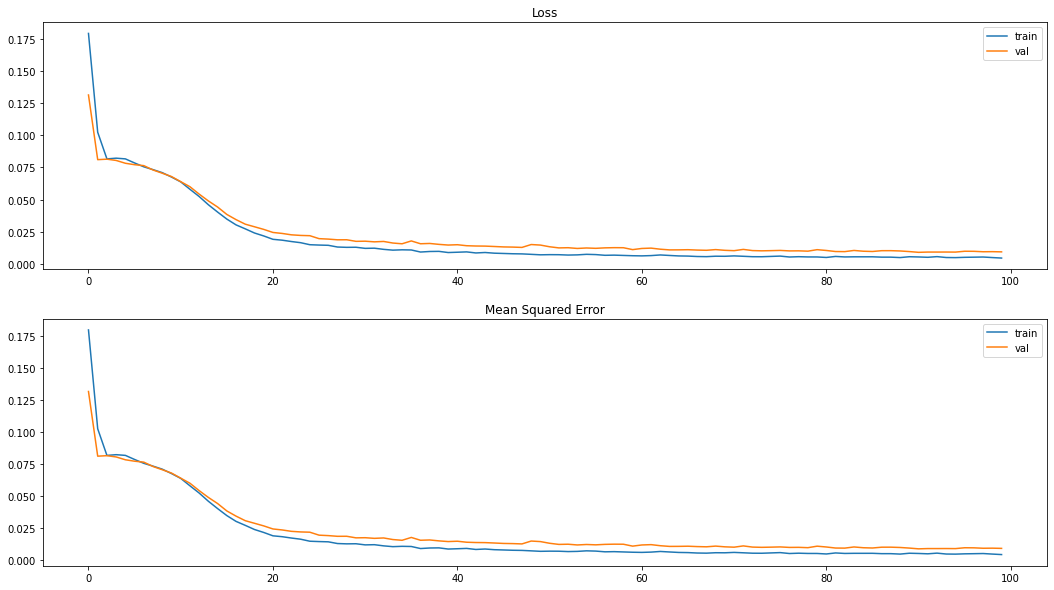

Experiment:  7, optimizer: adamax, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 3s 7ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 0.0795 - val_mse: 0.0795

Epoch 00001: loss improved from inf to 0.09367, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_7.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0821 - mse: 0.0821 - val_loss: 0.0771 - val_mse: 0.0771

Epoch 00002: loss improved from 0.09367 to 0.08277, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_7.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0783 - mse: 0.0783 - val_loss: 0.0668 - val_mse: 0.0668

Epoch 00003: loss improved from 0.08277 to 0.07586, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_7.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0477 - val_mse: 0.0477

Epoch 00004: loss impro

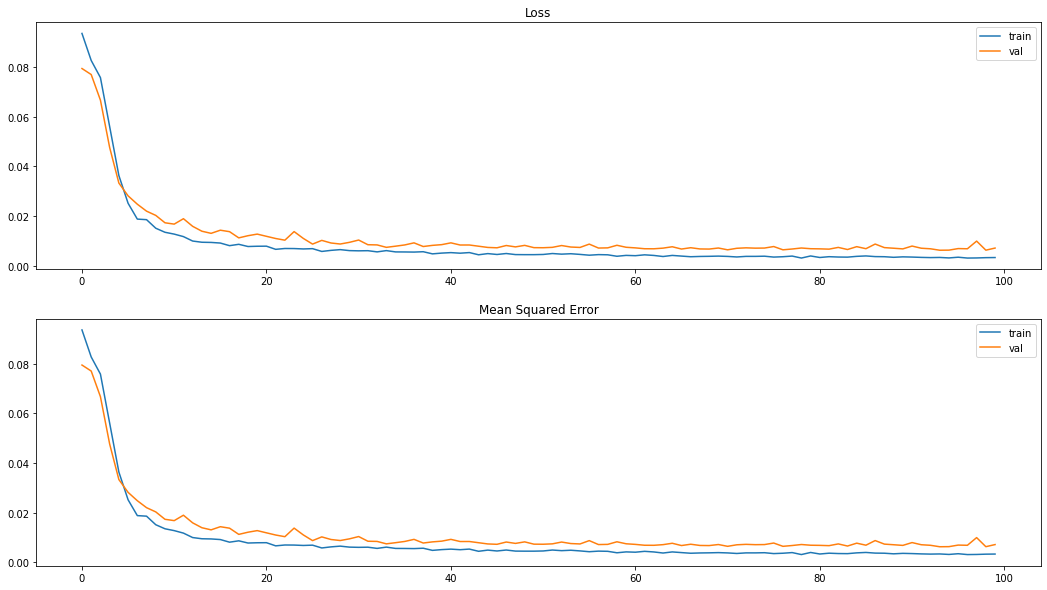

Experiment:  8, optimizer: adamax, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 2s 6ms/step - loss: 0.1730 - mse: 0.1730 - val_loss: 0.1143 - val_mse: 0.1143

Epoch 00001: loss improved from inf to 0.16501, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_8.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.1085 - mse: 0.1085 - val_loss: 0.0823 - val_mse: 0.0823

Epoch 00002: loss improved from 0.16501 to 0.09748, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_8.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0886 - mse: 0.0886 - val_loss: 0.0818 - val_mse: 0.0818

Epoch 00003: loss improved from 0.09748 to 0.08492, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_8.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0890 - mse: 0.0890 - val_loss: 0.0814 - val_mse: 0.0814

Epoch 00004: loss impro

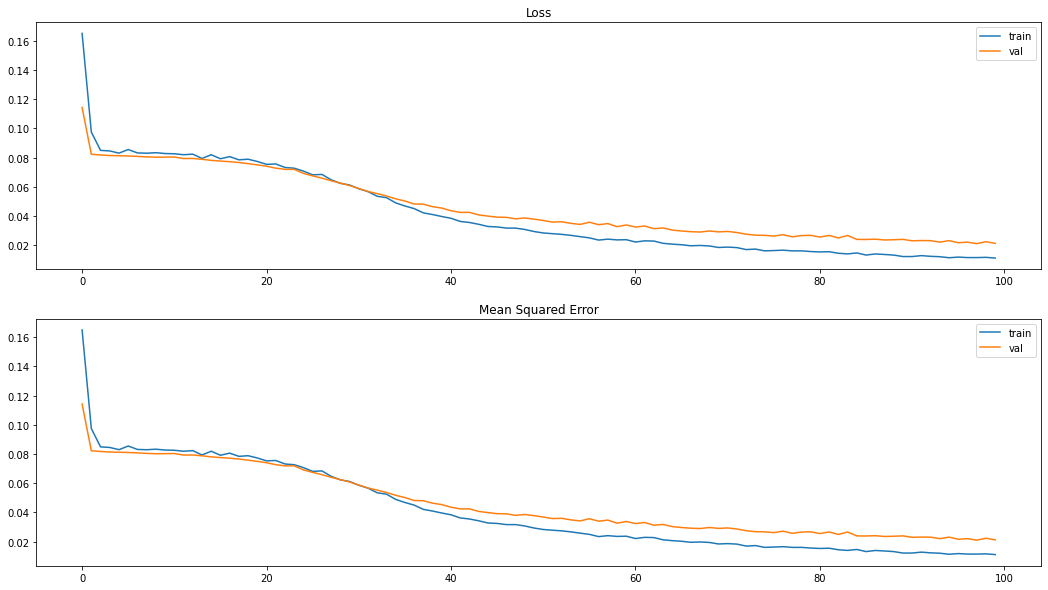

Experiment:  9, optimizer: adamax, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 1s 7ms/step - loss: 0.1247 - mse: 0.1247 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00001: loss improved from inf to 0.09693, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_9.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0796 - mse: 0.0796 - val_loss: 0.0767 - val_mse: 0.0767

Epoch 00002: loss improved from 0.09693 to 0.08120, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_9.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0795 - mse: 0.0795 - val_loss: 0.0699 - val_mse: 0.0699

Epoch 00003: loss improved from 0.08120 to 0.07604, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_9.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0695 - mse: 0.0695 - val_loss: 0.0566 - val_mse: 0.0566

Epoch 00004: loss impro

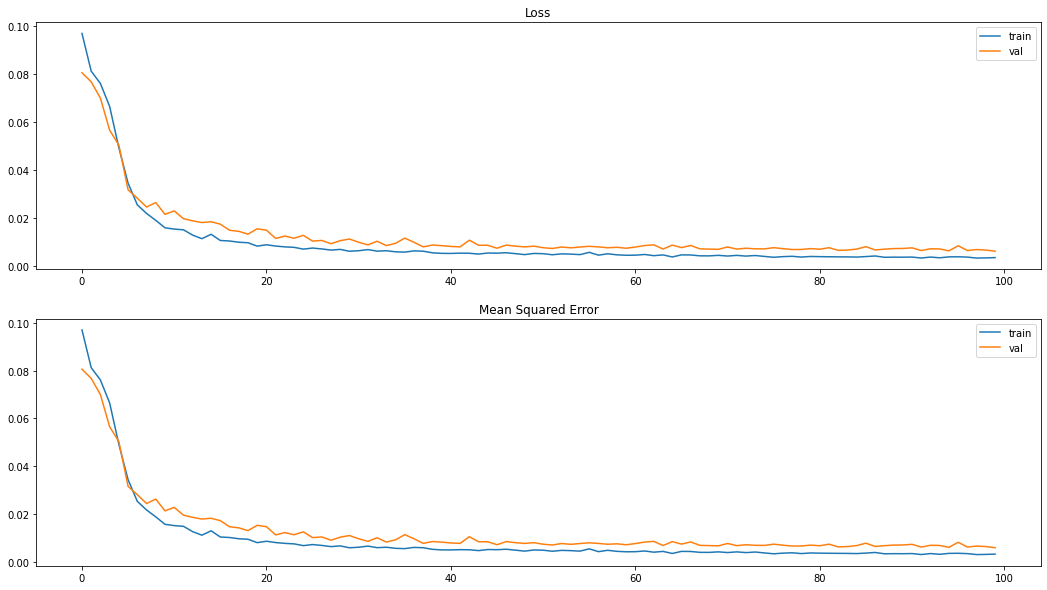

Experiment: 10, optimizer: adamax, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.1990 - mse: 0.1990 - val_loss: 0.1453 - val_mse: 0.1453

Epoch 00001: loss improved from inf to 0.18259, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_10.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.0970 - val_mse: 0.0970

Epoch 00002: loss improved from 0.18259 to 0.12796, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_10.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0997 - mse: 0.0997 - val_loss: 0.0824 - val_mse: 0.0824

Epoch 00003: loss improved from 0.12796 to 0.09263, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_10.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0816 - val_mse: 0.0816

Epoch 00004: loss im

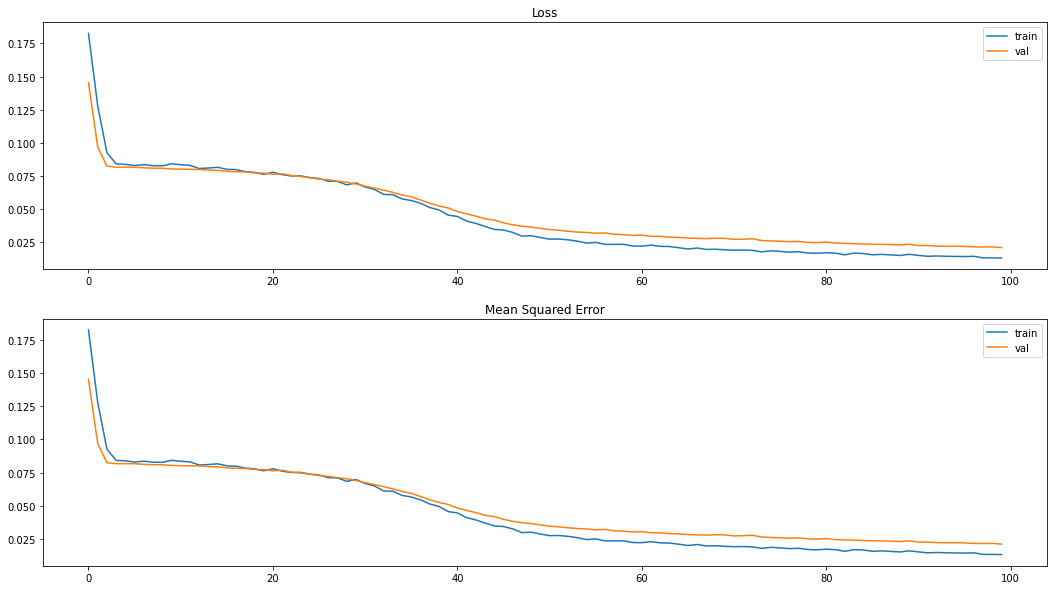

Experiment: 11, optimizer: adamax, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1392 - mse: 0.1392 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00001: loss improved from inf to 0.10509, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_11.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0763 - mse: 0.0763 - val_loss: 0.0786 - val_mse: 0.0786

Epoch 00002: loss improved from 0.10509 to 0.08243, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_11.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0735 - val_mse: 0.0735

Epoch 00003: loss improved from 0.08243 to 0.07808, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_11.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0641 - val_mse: 0.0641

Epoch 00004: loss improved f

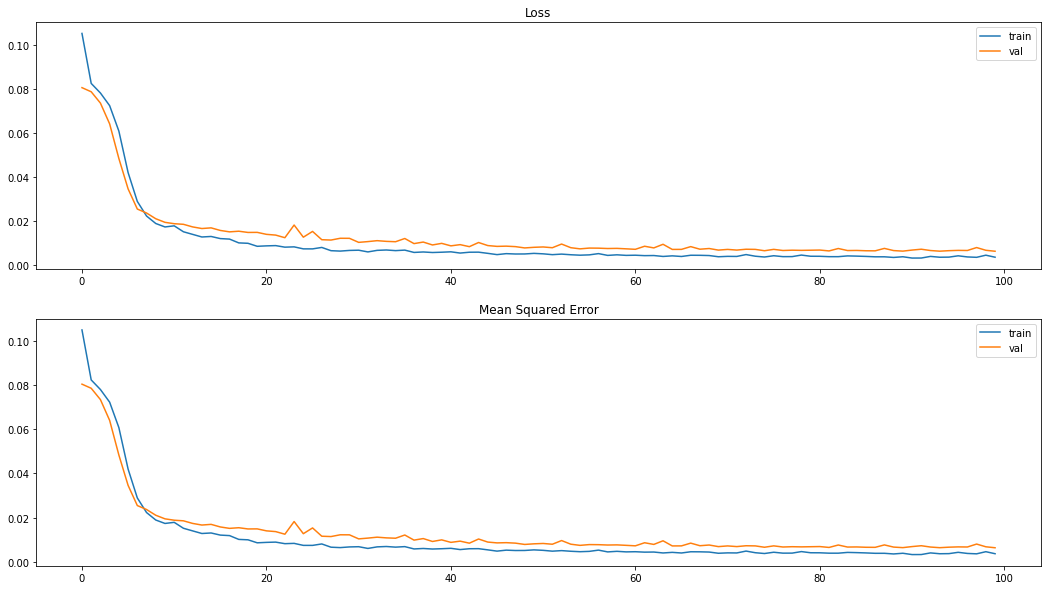

Experiment: 12, optimizer: adamax, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1963 - mse: 0.1963 - val_loss: 0.1566 - val_mse: 0.1566

Epoch 00001: loss improved from inf to 0.18779, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_12.h5
Epoch 2/100
88/88 [==============================] - 1s 6ms/step - loss: 0.1547 - mse: 0.1547 - val_loss: 0.1144 - val_mse: 0.1144

Epoch 00002: loss improved from 0.18779 to 0.14587, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_12.h5
Epoch 3/100
88/88 [==============================] - 1s 6ms/step - loss: 0.1162 - mse: 0.1162 - val_loss: 0.0875 - val_mse: 0.0875

Epoch 00003: loss improved from 0.14587 to 0.10572, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_12.h5
Epoch 4/100
88/88 [==============================] - 1s 6ms/step - loss: 0.0925 - mse: 0.0925 - val_loss: 0.0815 - val_mse: 0.0815

Epoch 00004: loss improved f

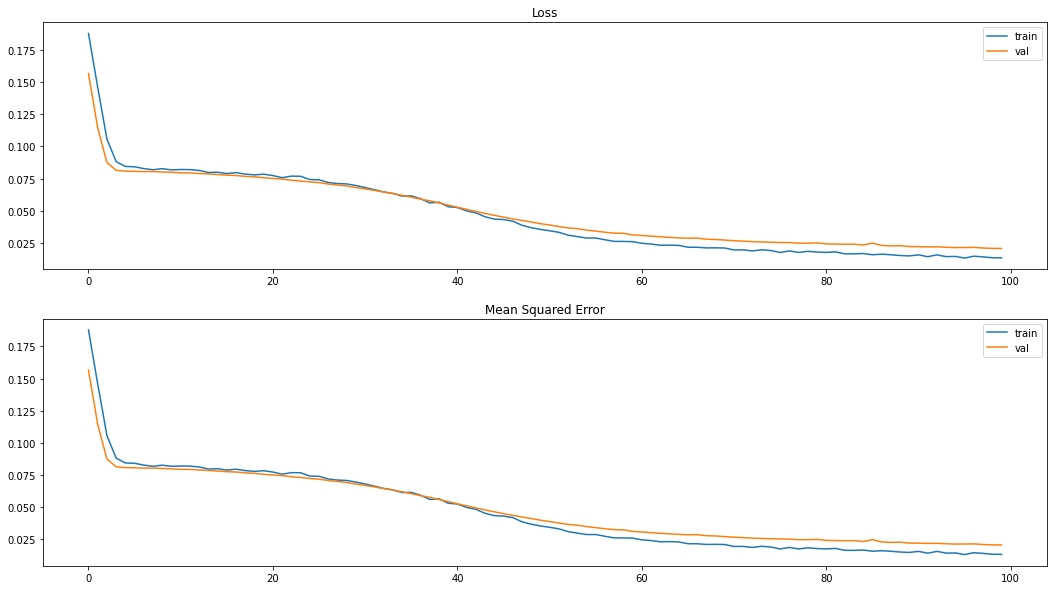

Experiment: 13, optimizer: nadam, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 6s 16ms/step - loss: 0.1066 - mse: 0.1066 - val_loss: 0.0524 - val_mse: 0.0524

Epoch 00001: loss improved from inf to 0.08298, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_13.h5
Epoch 2/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0249 - val_mse: 0.0249

Epoch 00002: loss improved from 0.08298 to 0.03373, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_13.h5
Epoch 3/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0171 - val_mse: 0.0171

Epoch 00003: loss improved from 0.03373 to 0.02010, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_13.h5
Epoch 4/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0151 - val_mse: 0.0151

Epoch 00004: loss

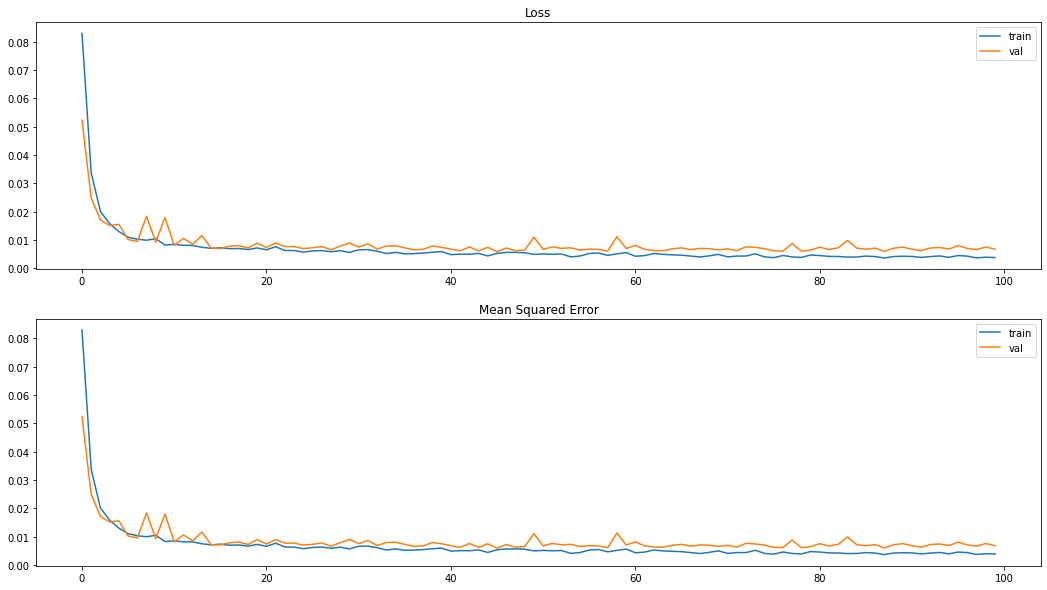

Experiment: 14, optimizer: nadam, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 6s 16ms/step - loss: 0.1551 - mse: 0.1551 - val_loss: 0.0797 - val_mse: 0.0797

Epoch 00001: loss improved from inf to 0.11335, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_14.h5
Epoch 2/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0809 - mse: 0.0809 - val_loss: 0.0791 - val_mse: 0.0791

Epoch 00002: loss improved from 0.11335 to 0.08103, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_14.h5
Epoch 3/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0744 - val_mse: 0.0744

Epoch 00003: loss improved from 0.08103 to 0.07794, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_14.h5
Epoch 4/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0701 - mse: 0.0701 - val_loss: 0.0697 - val_mse: 0.0697

Epoch 00004: loss

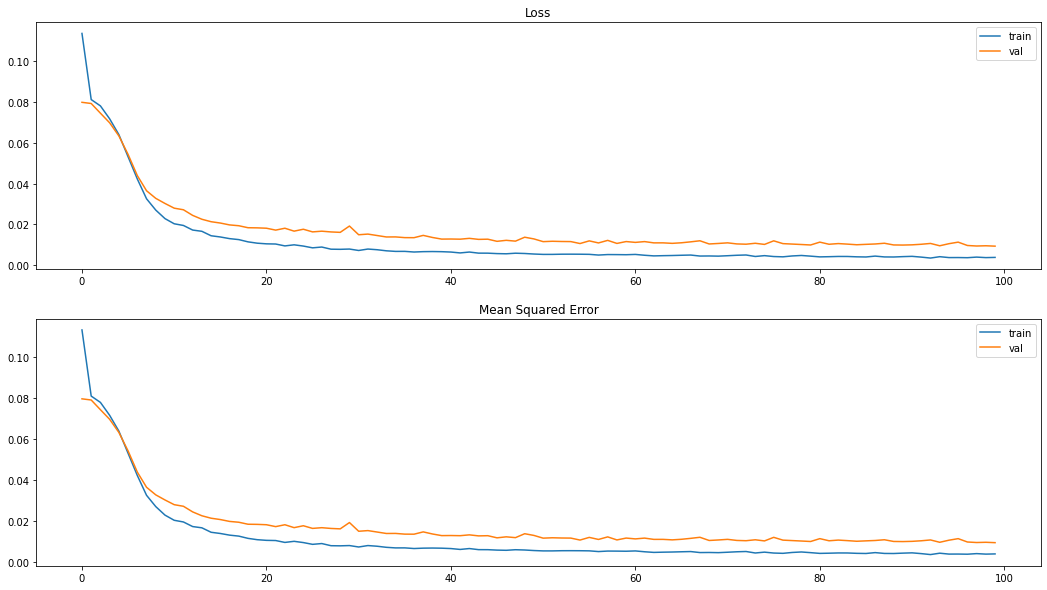

Experiment: 15, optimizer: nadam, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 4s 16ms/step - loss: 0.1128 - mse: 0.1128 - val_loss: 0.0667 - val_mse: 0.0667

Epoch 00001: loss improved from inf to 0.08986, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_15.h5
Epoch 2/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0292 - val_mse: 0.0292

Epoch 00002: loss improved from 0.08986 to 0.04755, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_15.h5
Epoch 3/100
175/175 [==============================] - 3s 16ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0168 - val_mse: 0.0168

Epoch 00003: loss improved from 0.04755 to 0.02131, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_15.h5
Epoch 4/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0199 - val_mse: 0.0199

Epoch 00004: loss

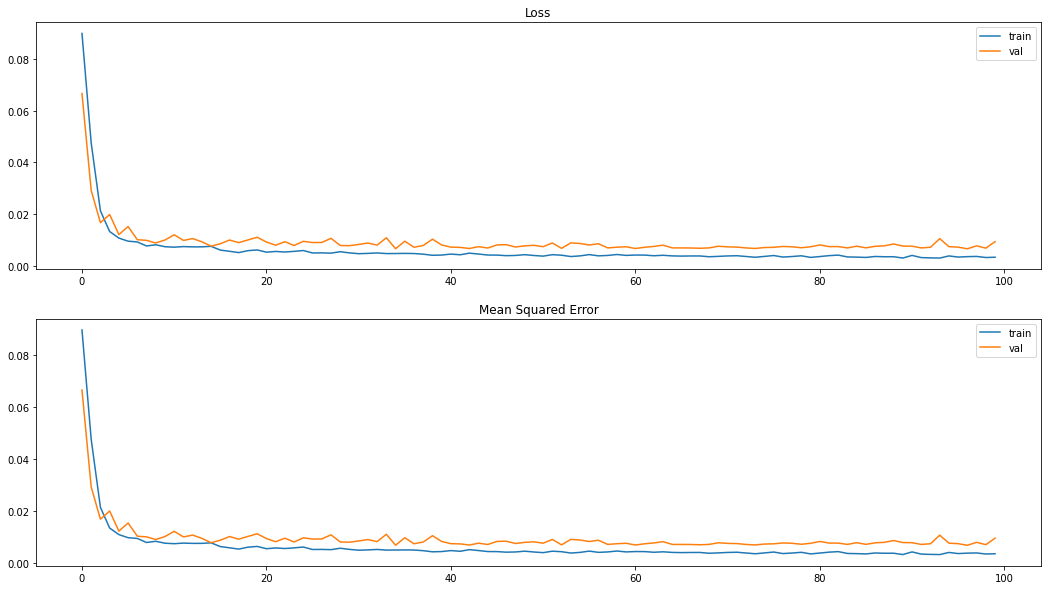

Experiment: 16, optimizer: nadam, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 4s 17ms/step - loss: 0.1803 - mse: 0.1803 - val_loss: 0.0818 - val_mse: 0.0818

Epoch 00001: loss improved from inf to 0.14653, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_16.h5
Epoch 2/100
175/175 [==============================] - 3s 16ms/step - loss: 0.0840 - mse: 0.0840 - val_loss: 0.0802 - val_mse: 0.0802

Epoch 00002: loss improved from 0.14653 to 0.08364, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_16.h5
Epoch 3/100
175/175 [==============================] - 3s 16ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0789 - val_mse: 0.0789

Epoch 00003: loss did not improve from 0.08364
Epoch 4/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0734 - mse: 0.0734 - val_loss: 0.0773 - val_mse: 0.0773

Epoch 00004: loss improved from 0.08364 to 0.08175, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_5

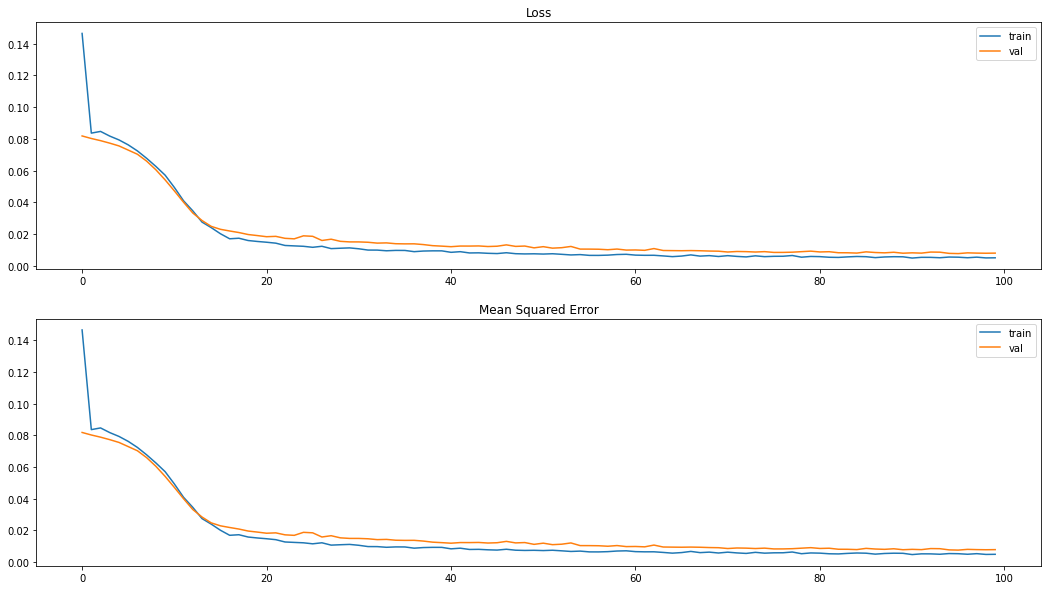

Experiment: 17, optimizer: nadam, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 2s 17ms/step - loss: 0.1149 - mse: 0.1149 - val_loss: 0.0741 - val_mse: 0.0741

Epoch 00001: loss improved from inf to 0.09405, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_17.h5
Epoch 2/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 0.0420 - val_mse: 0.0420

Epoch 00002: loss improved from 0.09405 to 0.06071, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_17.h5
Epoch 3/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0276 - val_mse: 0.0276

Epoch 00003: loss improved from 0.06071 to 0.02653, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_17.h5
Epoch 4/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0198 - val_mse: 0.0198

Epoch 00004: loss improve

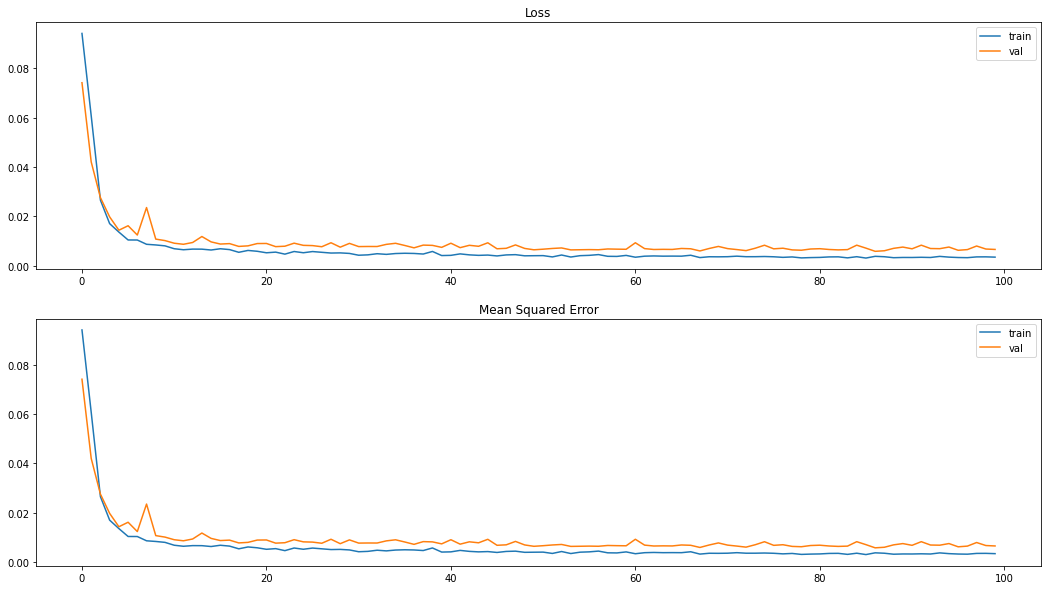

Experiment: 18, optimizer: nadam, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 2s 17ms/step - loss: 0.1952 - mse: 0.1952 - val_loss: 0.1141 - val_mse: 0.1141

Epoch 00001: loss improved from inf to 0.17280, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_18.h5
Epoch 2/100
88/88 [==============================] - 1s 15ms/step - loss: 0.1055 - mse: 0.1055 - val_loss: 0.0820 - val_mse: 0.0820

Epoch 00002: loss improved from 0.17280 to 0.09338, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_18.h5
Epoch 3/100
88/88 [==============================] - 1s 15ms/step - loss: 0.0840 - mse: 0.0840 - val_loss: 0.0813 - val_mse: 0.0813

Epoch 00003: loss improved from 0.09338 to 0.08369, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_irelu_m3_multiopt_18.h5
Epoch 4/100
88/88 [==============================] - 1s 15ms/step - loss: 0.0791 - mse: 0.0791 - val_loss: 0.0803 - val_mse: 0.0803

Epoch 00004: loss improve

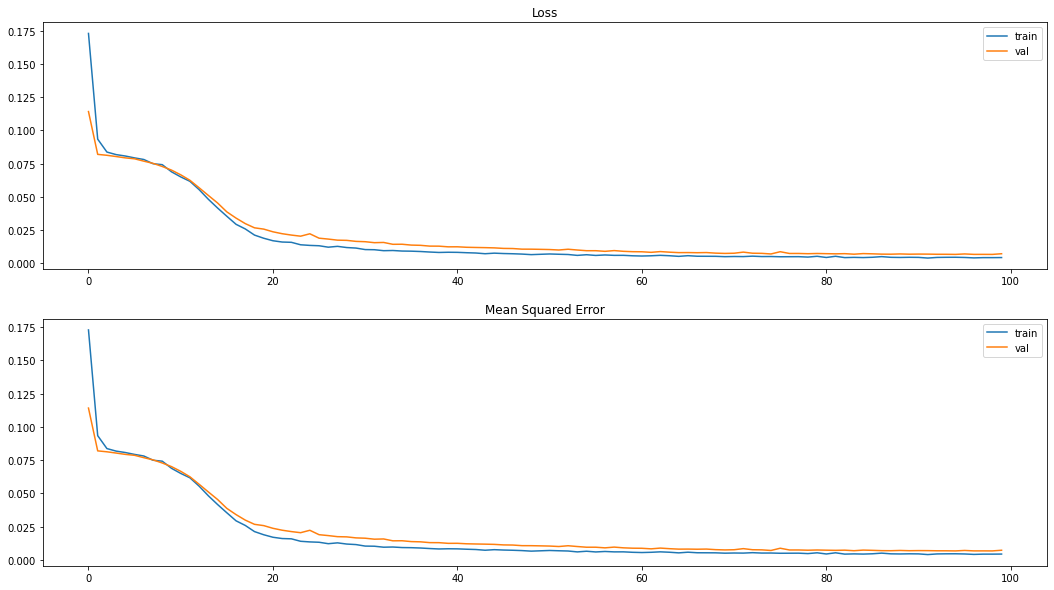

Total elapsed training time was: 3388.6898894310 seconds
Total elapsed training time was:  0.9413027470641666  hours


In [9]:
results_df = train_explore_model(exp_name= base_name+'_irelu_m3_multiopt', n_epochs=100, model_sel=3,
                                 in_dim_s = x_train.shape[1], in_act = 'relu', out_act = None,
                                 x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_tst=x_tst, y_tst=y_tst)

In [10]:
results_df

exp_name exp_number optimizer b_s      lr  trn_loss  \
0   pe_e4_50a50b_irelu_m3_multiopt          6      adam   8  0.0010  0.002980   
1   pe_e4_50a50b_irelu_m3_multiopt         18     nadam   8  0.0010  0.003078   
2   pe_e4_50a50b_irelu_m3_multiopt          3      adam   2  0.0001  0.003413   
3   pe_e4_50a50b_irelu_m3_multiopt         10    adamax   4  0.0010  0.003207   
4   pe_e4_50a50b_irelu_m3_multiopt         17     nadam   4  0.0001  0.004802   
5   pe_e4_50a50b_irelu_m3_multiopt         19     nadam   8  0.0001  0.004084   
6   pe_e4_50a50b_irelu_m3_multiopt         12    adamax   8  0.0010  0.003238   
7   pe_e4_50a50b_irelu_m3_multiopt          5      adam   4  0.0001  0.004647   
8   pe_e4_50a50b_irelu_m3_multiopt          2      adam   2  0.0010  0.003702   
9   pe_e4_50a50b_irelu_m3_multiopt          8    adamax   2  0.0010  0.003035   
10  pe_e4_50a50b_irelu_m3_multiopt          4      adam   4  0.0010  0.003315   
11  pe_e4_50a50b_irelu_m3_multiopt         14     nadam   2  0.0010  0.003635   
12  pe_e4_50a50b_irelu_m3_multiopt          7      adam   8  0.0001  0.004317   
13  pe_e4_50a50b_irelu_m3_multiopt         16     nadam   4  0.0010  0.003083   
14  pe_e4_50a50b_irelu_m3_multiopt         15     nadam   2  0.0001  0.003587   
15  pe_e4_50a50b_irelu_m3_multiopt          9    adamax   2  0.0001  0.011184   
16  pe_e4_50a50b_irelu_m3_multiopt         13    adamax   8  0.0001  0.013265   
17  pe_e4_50a50b_irelu_m3_multiopt         11    adamax   4  0.0001  0.013078   

     trn_mse  val_loss   val_mse   tst_mse  
0   0.002980  0.006022  0.006022  0.004711  
1   0.003078  0.007094  0.007094  0.005105  
2   0.003413  0.007124  0.007124  0.005959  
3   0.003207  0.006747  0.006747  0.006052  
4   0.004802  0.008099  0.008099  0.006144  
5   0.004084  0.007038  0.007038  0.006202  
6   0.003238  0.006859  0.006859  0.006277  
7   0.004647  0.006829  0.006829  0.006319  
8   0.003702  0.007233  0.007233  0.006408  
9   0.003035  0.006782  0.006782  0.006431  
10  0.003315  0.006569  0.006569  0.006735  
11  0.003635  0.005994  0.005994  0.007059  
12  0.004317  0.009153  0.009153  0.007469  
13  0.003083  0.010583  0.010583  0.007551  
14  0.003587  0.010731  0.010731  0.008087  
15  0.011184  0.021263  0.021263  0.015932  
16  0.013265  0.021473  0.021473  0.021323  
17  0.013078  0.020962  0.020962  0.022374

## 0.2. ReLu intermedia - final

### 0.2.2. Model 2

Experiment:  1, optimizer: adam, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 3s 6ms/step - loss: 0.0990 - mse: 0.0990 - val_loss: 0.0597 - val_mse: 0.0597

Epoch 00001: loss improved from inf to 0.08538, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_1.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0180 - val_mse: 0.0180

Epoch 00002: loss improved from 0.08538 to 0.03700, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_1.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0124 - val_mse: 0.0124

Epoch 00003: loss improved from 0.03700 to 0.01584, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_1.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0141 - val_mse: 0.0141

Epoch 00004: loss impr

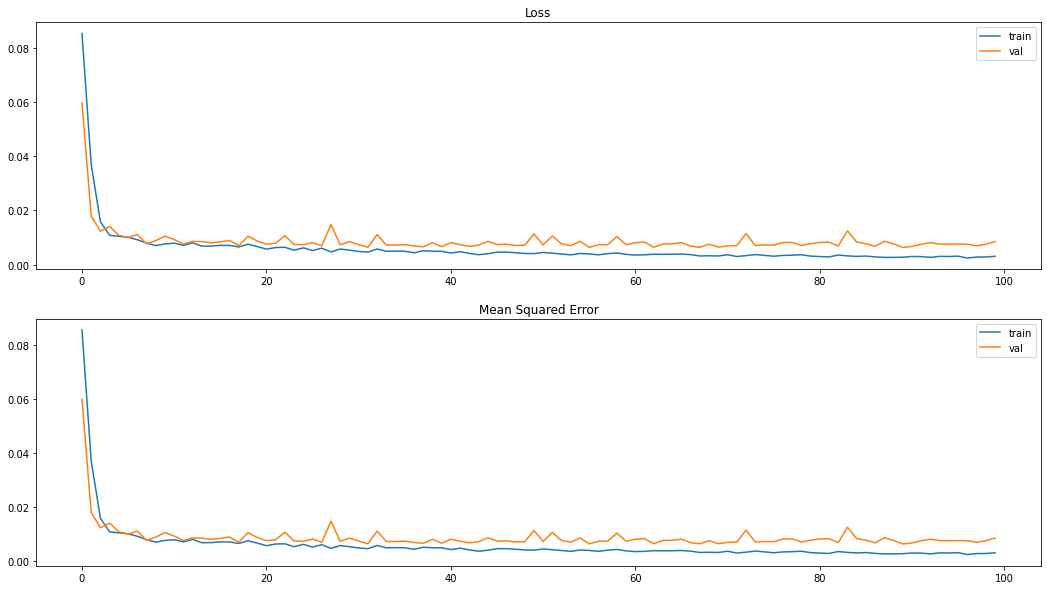

Experiment:  2, optimizer: adam, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 3s 6ms/step - loss: 0.1429 - mse: 0.1429 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00001: loss improved from inf to 0.11090, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_2.h5
Epoch 2/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 0.0784 - val_mse: 0.0784

Epoch 00002: loss improved from 0.11090 to 0.08101, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_2.h5
Epoch 3/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 0.0752 - val_mse: 0.0752

Epoch 00003: loss improved from 0.08101 to 0.07912, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_2.h5
Epoch 4/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.0699 - val_mse: 0.0699

Epoch 00004: loss impr

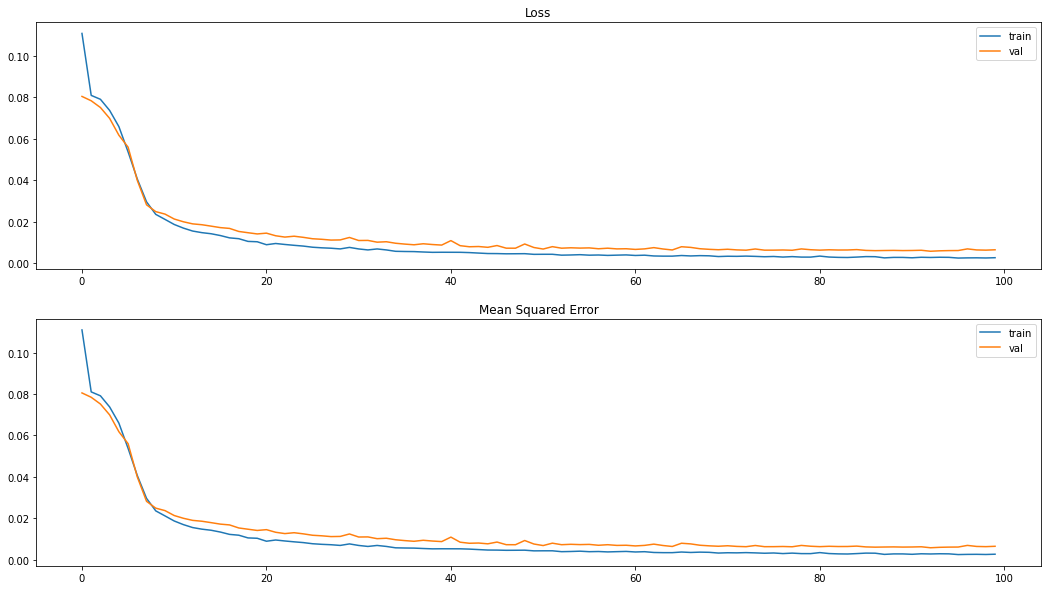

Experiment:  3, optimizer: adam, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.0978 - mse: 0.0978 - val_loss: 0.0722 - val_mse: 0.0722

Epoch 00001: loss improved from inf to 0.08758, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_3.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0328 - val_mse: 0.0328

Epoch 00002: loss improved from 0.08758 to 0.05247, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_3.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0220 - val_mse: 0.0220

Epoch 00003: loss improved from 0.05247 to 0.02761, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_3.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0171 - val_mse: 0.0171

Epoch 00004: loss impr

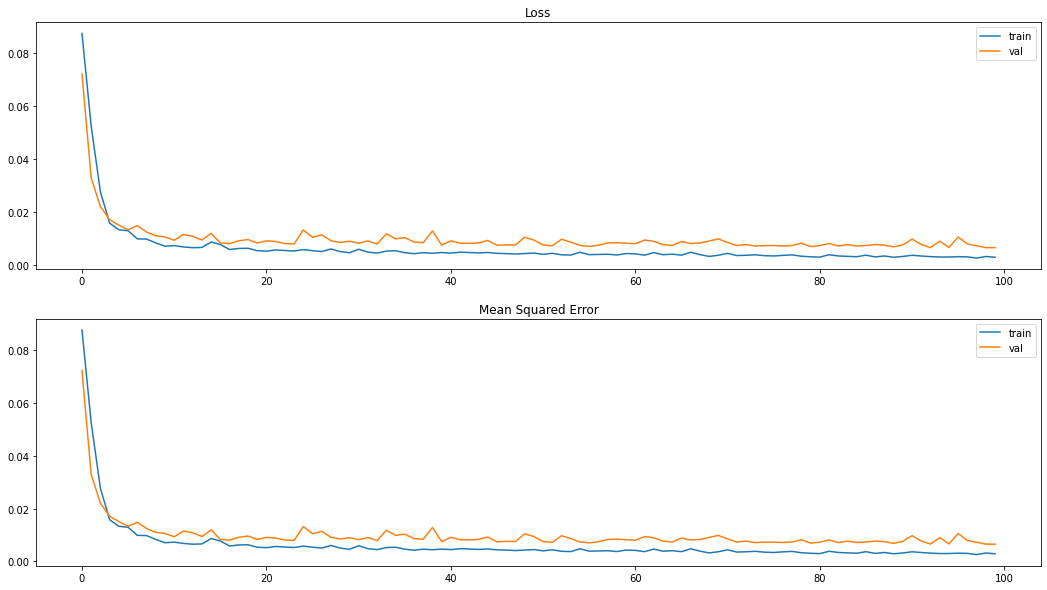

Experiment:  4, optimizer: adam, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.1709 - mse: 0.1709 - val_loss: 0.0818 - val_mse: 0.0818

Epoch 00001: loss improved from inf to 0.13813, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_4.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0909 - mse: 0.0909 - val_loss: 0.0802 - val_mse: 0.0802

Epoch 00002: loss improved from 0.13813 to 0.08269, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_4.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0795 - mse: 0.0795 - val_loss: 0.0788 - val_mse: 0.0788

Epoch 00003: loss improved from 0.08269 to 0.08036, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_4.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0789 - mse: 0.0789 - val_loss: 0.0776 - val_mse: 0.0776

Epoch 00004: loss impr

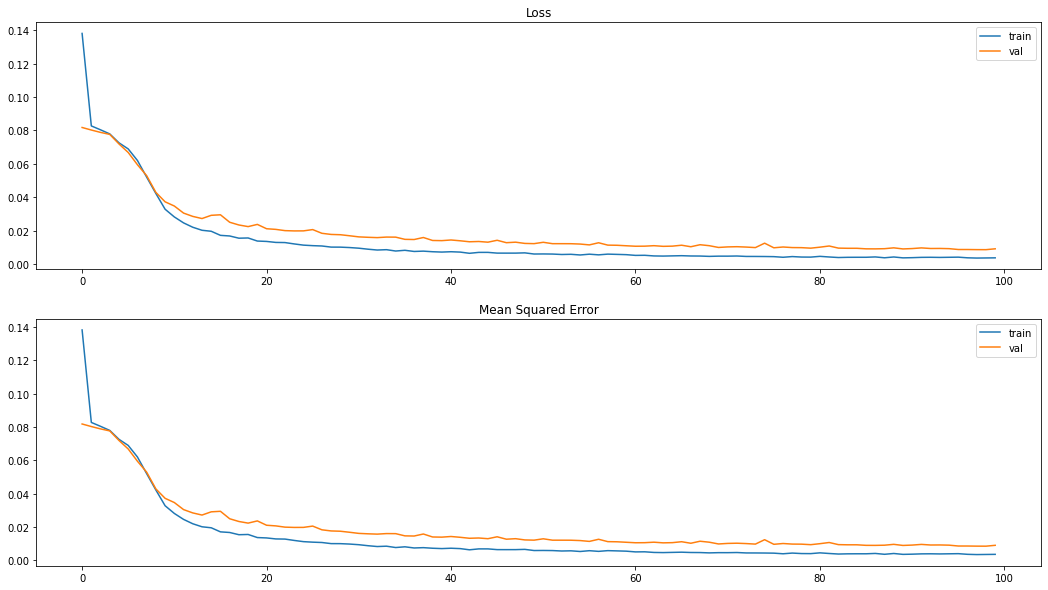

Experiment:  5, optimizer: adam, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1652 - mse: 0.1652 - val_loss: 0.0784 - val_mse: 0.0784

Epoch 00001: loss improved from inf to 0.12123, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_5.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0514 - val_mse: 0.0514

Epoch 00002: loss improved from 0.12123 to 0.07386, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_5.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0263 - val_mse: 0.0263

Epoch 00003: loss improved from 0.07386 to 0.03119, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_5.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0228 - val_mse: 0.0228

Epoch 00004: loss improved fro

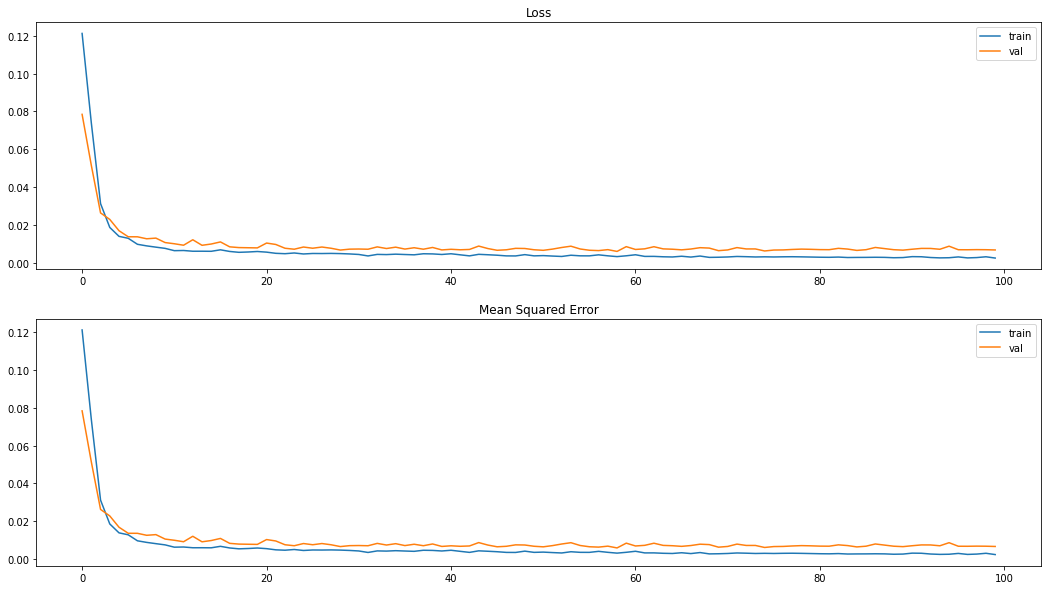

Experiment:  6, optimizer: adam, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1787 - mse: 0.1787 - val_loss: 0.0970 - val_mse: 0.0970

Epoch 00001: loss improved from inf to 0.16207, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_6.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00002: loss improved from 0.16207 to 0.08488, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_6.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0824 - mse: 0.0824 - val_loss: 0.0788 - val_mse: 0.0788

Epoch 00003: loss improved from 0.08488 to 0.08149, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_6.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0783 - val_mse: 0.0783

Epoch 00004: loss improved fro

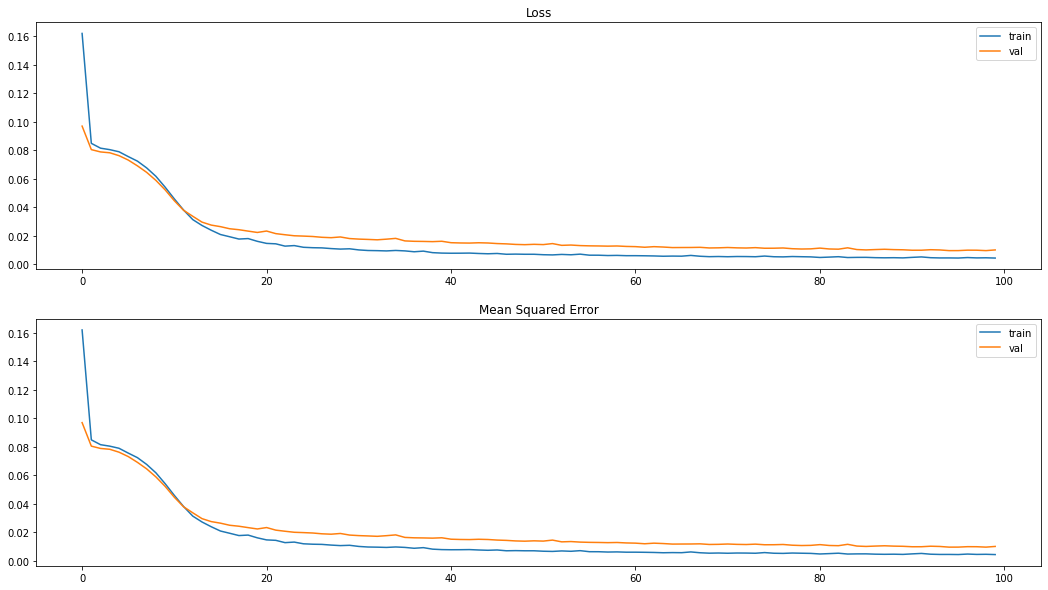

Experiment:  7, optimizer: adamax, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 3s 7ms/step - loss: 0.1373 - mse: 0.1373 - val_loss: 0.0774 - val_mse: 0.0774

Epoch 00001: loss improved from inf to 0.09686, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_7.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0791 - mse: 0.0791 - val_loss: 0.0680 - val_mse: 0.0680

Epoch 00002: loss improved from 0.09686 to 0.07387, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_7.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0562 - mse: 0.0562 - val_loss: 0.0397 - val_mse: 0.0397

Epoch 00003: loss improved from 0.07387 to 0.05238, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_7.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0315 - val_mse: 0.0315

Epoch 00004: loss im

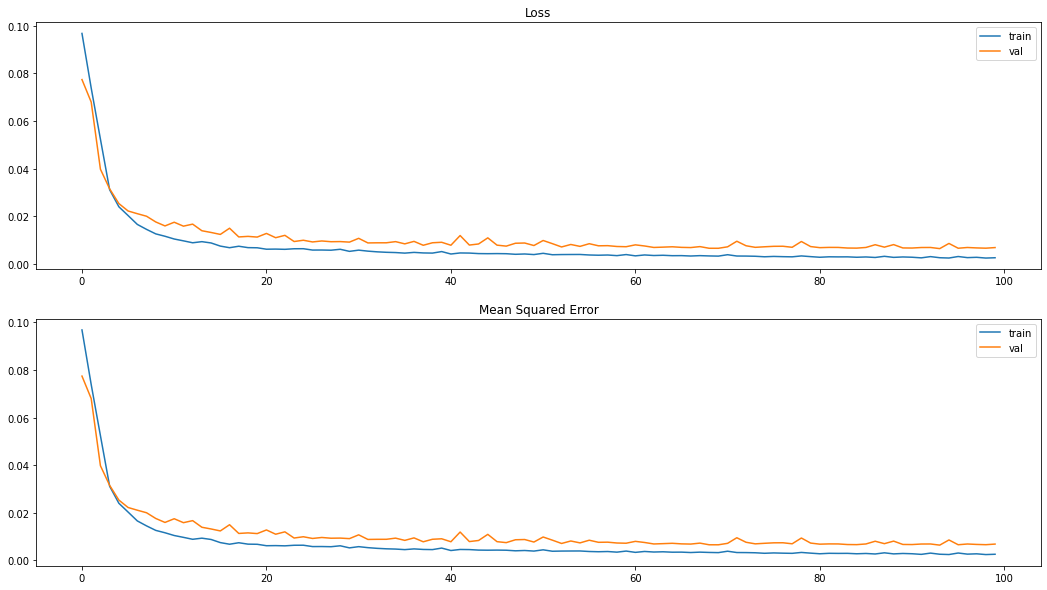

Experiment:  8, optimizer: adamax, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 3s 7ms/step - loss: 0.1799 - mse: 0.1799 - val_loss: 0.1065 - val_mse: 0.1065

Epoch 00001: loss improved from inf to 0.15901, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_8.h5
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0972 - mse: 0.0972 - val_loss: 0.0811 - val_mse: 0.0811

Epoch 00002: loss improved from 0.15901 to 0.09292, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_8.h5
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0800 - mse: 0.0800 - val_loss: 0.0815 - val_mse: 0.0815

Epoch 00003: loss improved from 0.09292 to 0.08317, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_8.h5
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0812 - val_mse: 0.0812

Epoch 00004: loss di

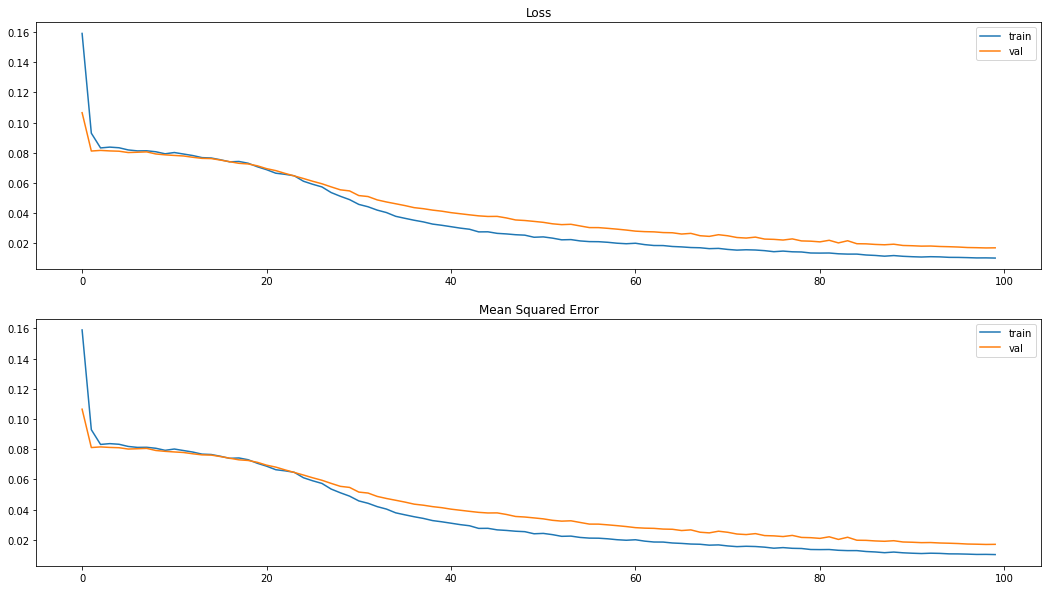

Experiment:  9, optimizer: adamax, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.1241 - mse: 0.1241 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00001: loss improved from inf to 0.09789, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_9.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.0799 - val_mse: 0.0799

Epoch 00002: loss improved from 0.09789 to 0.08197, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_9.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0780 - mse: 0.0780 - val_loss: 0.0771 - val_mse: 0.0771

Epoch 00003: loss improved from 0.08197 to 0.07762, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_9.h5
Epoch 4/100
175/175 [==============================] - 1s 7ms/step - loss: 0.0686 - mse: 0.0686 - val_loss: 0.0602 - val_mse: 0.0602

Epoch 00004: loss im

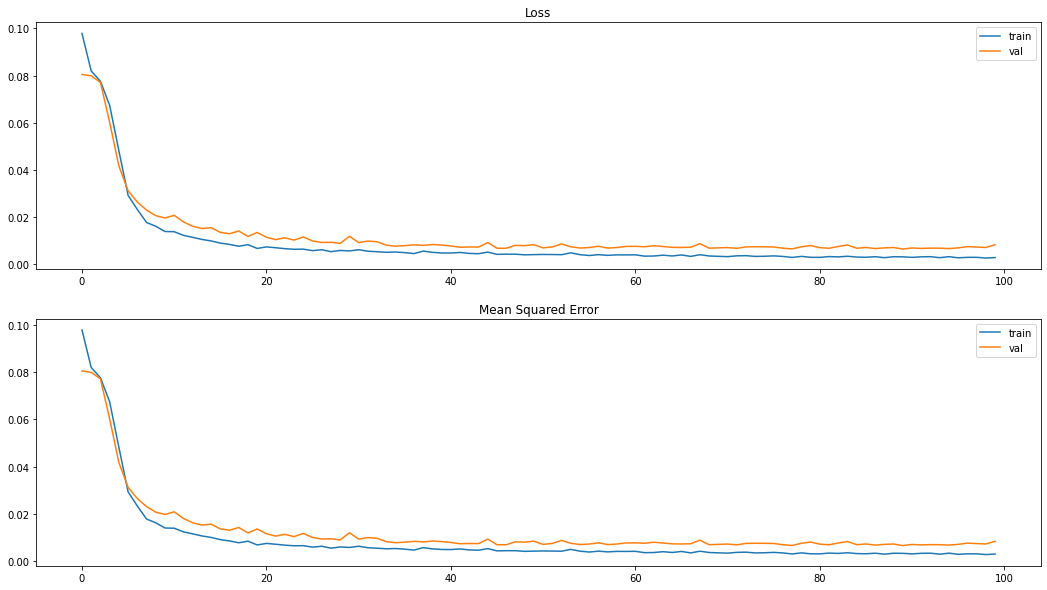

Experiment: 10, optimizer: adamax, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 2s 7ms/step - loss: 0.1740 - mse: 0.1740 - val_loss: 0.1536 - val_mse: 0.1536

Epoch 00001: loss improved from inf to 0.19033, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_10.h5
Epoch 2/100
175/175 [==============================] - 1s 6ms/step - loss: 0.1490 - mse: 0.1490 - val_loss: 0.1017 - val_mse: 0.1017

Epoch 00002: loss improved from 0.19033 to 0.13630, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_10.h5
Epoch 3/100
175/175 [==============================] - 1s 6ms/step - loss: 0.1009 - mse: 0.1009 - val_loss: 0.0819 - val_mse: 0.0819

Epoch 00003: loss improved from 0.13630 to 0.09384, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_10.h5
Epoch 4/100
175/175 [==============================] - 1s 6ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0813 - val_mse: 0.0813

Epoch 00004: loss

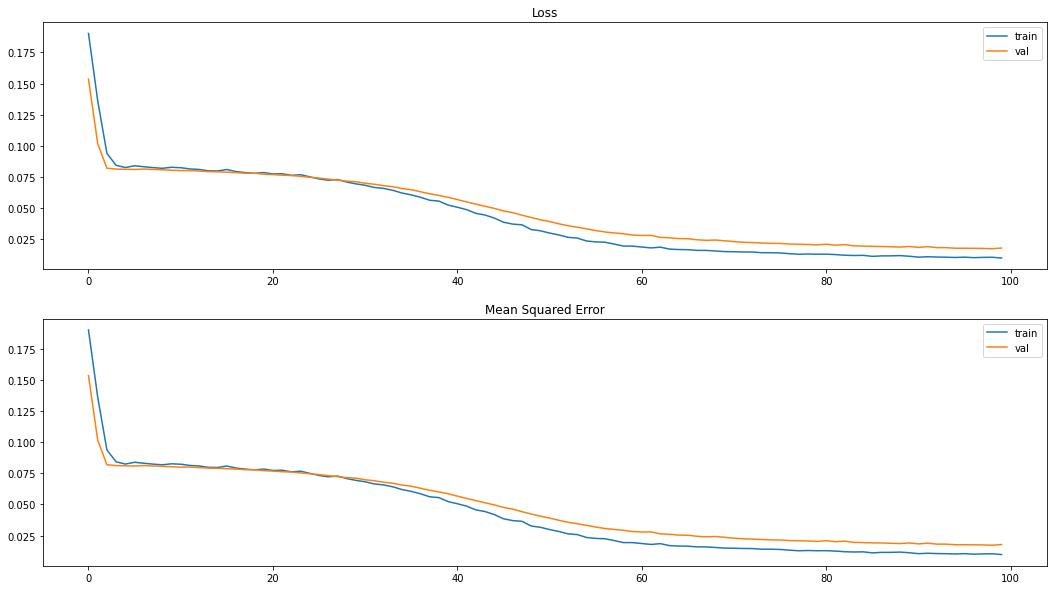

Experiment: 11, optimizer: adamax, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1316 - mse: 0.1316 - val_loss: 0.0805 - val_mse: 0.0805

Epoch 00001: loss improved from inf to 0.10212, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_11.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0864 - mse: 0.0864 - val_loss: 0.0786 - val_mse: 0.0786

Epoch 00002: loss improved from 0.10212 to 0.08283, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_11.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0757 - val_mse: 0.0757

Epoch 00003: loss improved from 0.08283 to 0.07803, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_11.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0681 - val_mse: 0.0681

Epoch 00004: loss improve

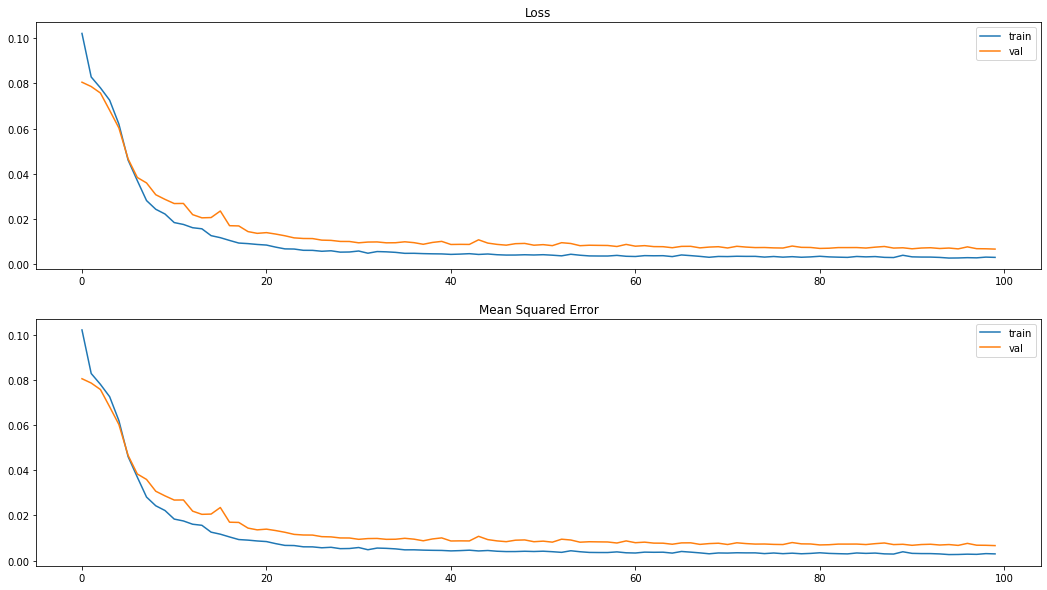

Experiment: 12, optimizer: adamax, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1979 - mse: 0.1979 - val_loss: 0.1490 - val_mse: 0.1490

Epoch 00001: loss improved from inf to 0.18366, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_12.h5
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.1546 - mse: 0.1546 - val_loss: 0.1043 - val_mse: 0.1043

Epoch 00002: loss improved from 0.18366 to 0.13599, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_12.h5
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0968 - mse: 0.0968 - val_loss: 0.0837 - val_mse: 0.0837

Epoch 00003: loss improved from 0.13599 to 0.09733, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_12.h5
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0898 - mse: 0.0898 - val_loss: 0.0813 - val_mse: 0.0813

Epoch 00004: loss improve

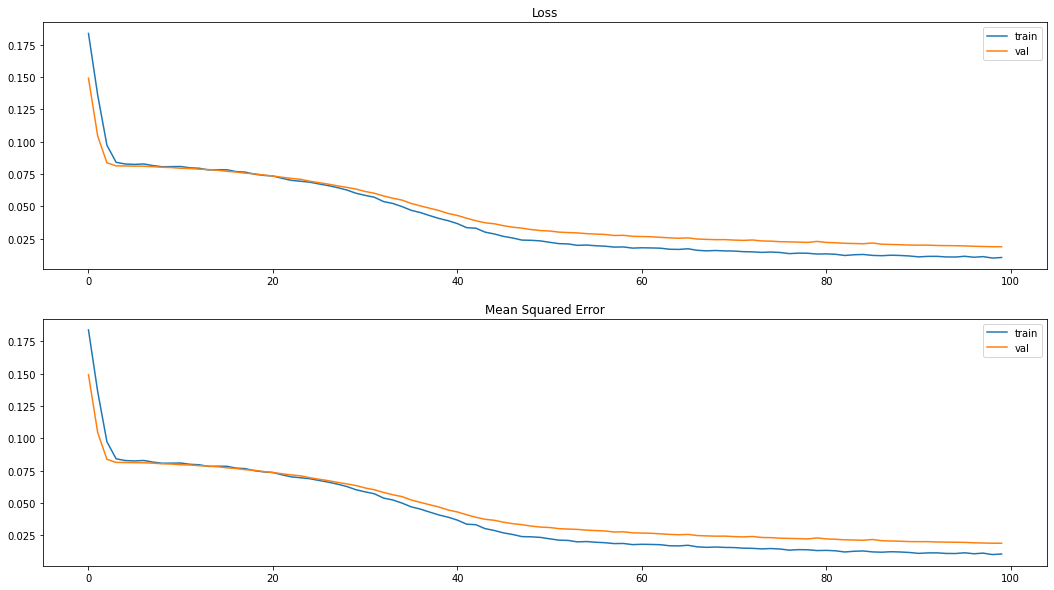

Experiment: 13, optimizer: nadam, bs:  2, lr:    1.0E-03
Epoch 1/100
350/350 [==============================] - 7s 17ms/step - loss: 0.1006 - mse: 0.1006 - val_loss: 0.0640 - val_mse: 0.0640

Epoch 00001: loss improved from inf to 0.08539, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_13.h5
Epoch 2/100
350/350 [==============================] - 6s 16ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0310 - val_mse: 0.0310

Epoch 00002: loss improved from 0.08539 to 0.04141, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_13.h5
Epoch 3/100
350/350 [==============================] - 6s 16ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0166 - val_mse: 0.0166

Epoch 00003: loss improved from 0.04141 to 0.01827, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_13.h5
Epoch 4/100
350/350 [==============================] - 5s 16ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0119 - val_mse: 0.0119

Epoch 00004: l

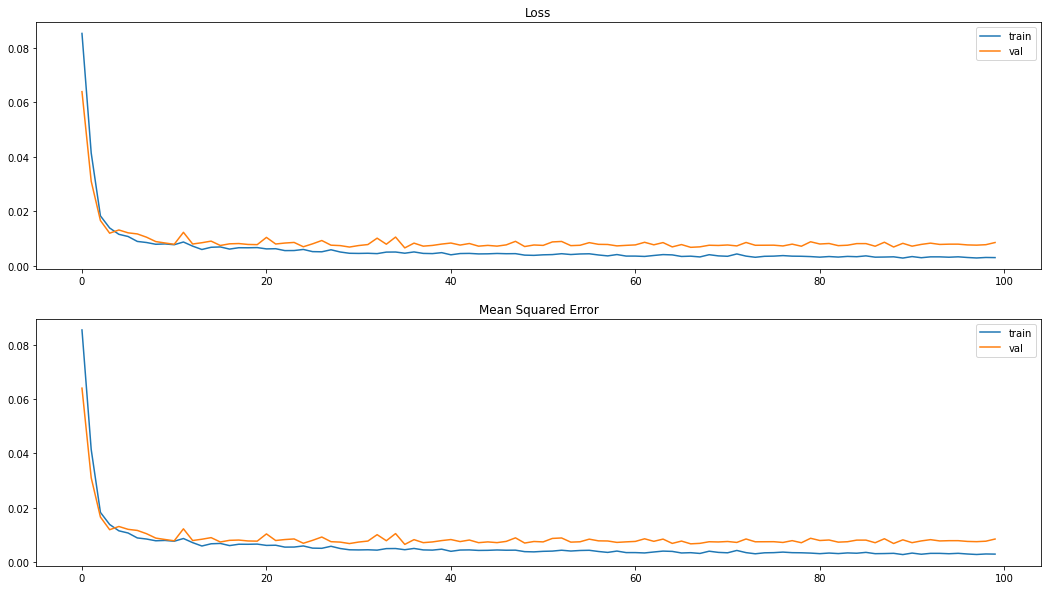

Experiment: 14, optimizer: nadam, bs:  2, lr:    1.0E-04
Epoch 1/100
350/350 [==============================] - 6s 16ms/step - loss: 0.2067 - mse: 0.2067 - val_loss: 0.1923 - val_mse: 0.1923

Epoch 00001: loss improved from inf to 0.20591, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_14.h5
Epoch 2/100
350/350 [==============================] - 5s 14ms/step - loss: 0.2014 - mse: 0.2014 - val_loss: 0.0824 - val_mse: 0.0824

Epoch 00002: loss improved from 0.20591 to 0.17221, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_14.h5
Epoch 3/100
350/350 [==============================] - 5s 14ms/step - loss: 0.0856 - mse: 0.0856 - val_loss: 0.0793 - val_mse: 0.0793

Epoch 00003: loss improved from 0.17221 to 0.08308, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_14.h5
Epoch 4/100
350/350 [==============================] - 5s 14ms/step - loss: 0.0838 - mse: 0.0838 - val_loss: 0.0748 - val_mse: 0.0748

Epoch 00004: l

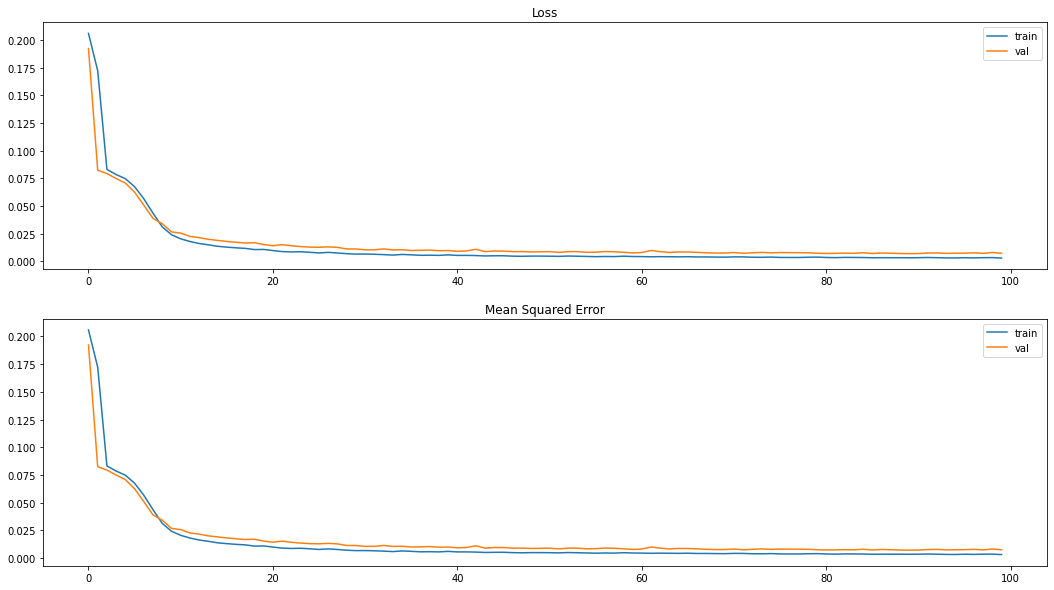

Experiment: 15, optimizer: nadam, bs:  4, lr:    1.0E-03
Epoch 1/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0994 - mse: 0.0994 - val_loss: 0.0584 - val_mse: 0.0584

Epoch 00001: loss improved from inf to 0.08518, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_15.h5
Epoch 2/100
175/175 [==============================] - 3s 14ms/step - loss: 0.0523 - mse: 0.0523 - val_loss: 0.0244 - val_mse: 0.0244

Epoch 00002: loss improved from 0.08518 to 0.04367, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_15.h5
Epoch 3/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0282 - val_mse: 0.0282

Epoch 00003: loss improved from 0.04367 to 0.01918, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_15.h5
Epoch 4/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0176 - val_mse: 0.0176

Epoch 00004: l

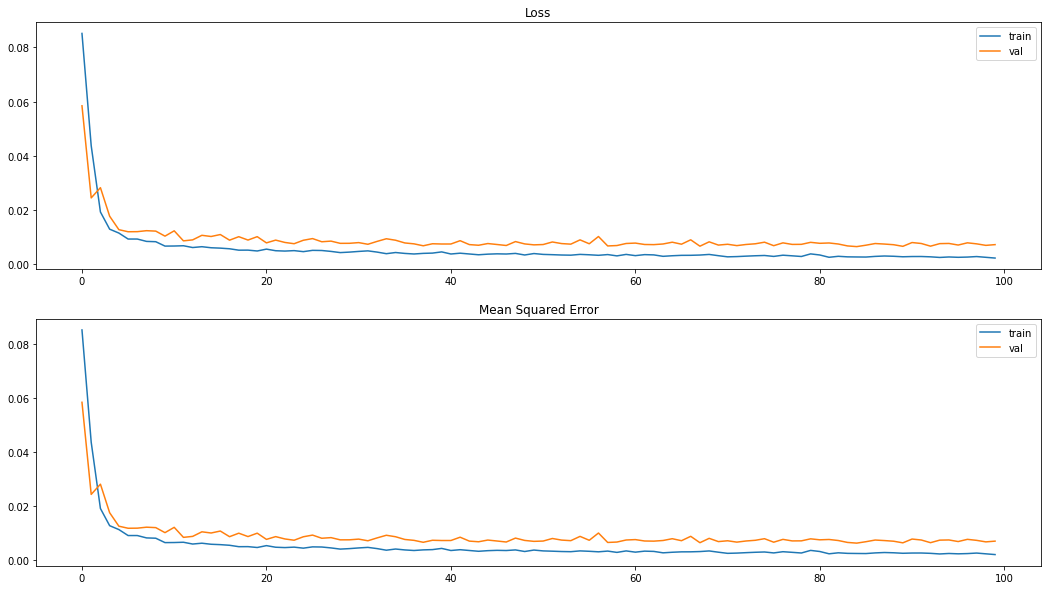

Experiment: 16, optimizer: nadam, bs:  4, lr:    1.0E-04
Epoch 1/100
175/175 [==============================] - 4s 16ms/step - loss: 0.1559 - mse: 0.1559 - val_loss: 0.0806 - val_mse: 0.0806

Epoch 00001: loss improved from inf to 0.12345, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_16.h5
Epoch 2/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0847 - mse: 0.0847 - val_loss: 0.0794 - val_mse: 0.0794

Epoch 00002: loss improved from 0.12345 to 0.08281, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_16.h5
Epoch 3/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0848 - mse: 0.0848 - val_loss: 0.0777 - val_mse: 0.0777

Epoch 00003: loss improved from 0.08281 to 0.08131, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_16.h5
Epoch 4/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0778 - mse: 0.0778 - val_loss: 0.0751 - val_mse: 0.0751

Epoch 00004: l

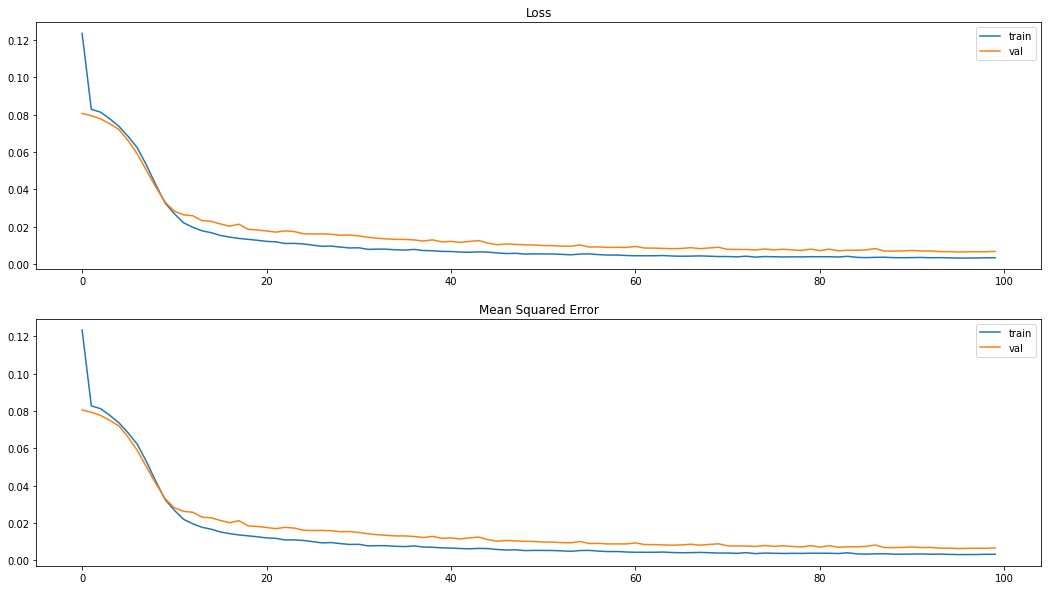

Experiment: 17, optimizer: nadam, bs:  8, lr:    1.0E-03
Epoch 1/100
88/88 [==============================] - 2s 17ms/step - loss: 0.1192 - mse: 0.1192 - val_loss: 0.0766 - val_mse: 0.0766

Epoch 00001: loss improved from inf to 0.09416, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_17.h5
Epoch 2/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0732 - mse: 0.0732 - val_loss: 0.0426 - val_mse: 0.0426

Epoch 00002: loss improved from 0.09416 to 0.06406, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_17.h5
Epoch 3/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0272 - val_mse: 0.0272

Epoch 00003: loss improved from 0.06406 to 0.02941, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_17.h5
Epoch 4/100
88/88 [==============================] - 1s 16ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0178 - val_mse: 0.0178

Epoch 00004: loss impr

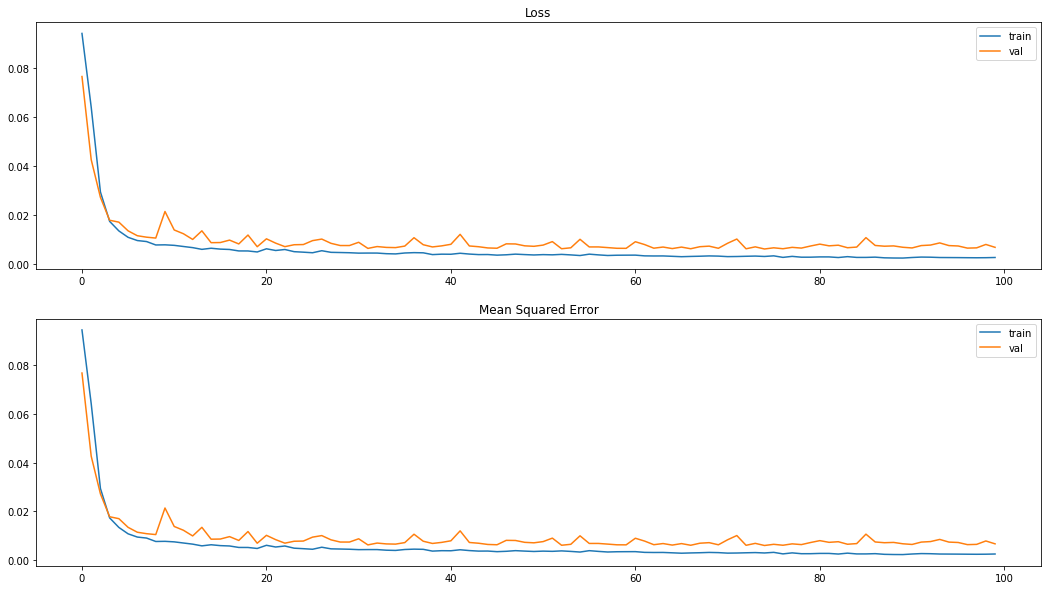

Experiment: 18, optimizer: nadam, bs:  8, lr:    1.0E-04
Epoch 1/100
88/88 [==============================] - 2s 17ms/step - loss: 0.1870 - mse: 0.1870 - val_loss: 0.0954 - val_mse: 0.0954

Epoch 00001: loss improved from inf to 0.16198, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_18.h5
Epoch 2/100
88/88 [==============================] - 1s 15ms/step - loss: 0.0931 - mse: 0.0931 - val_loss: 0.0793 - val_mse: 0.0793

Epoch 00002: loss improved from 0.16198 to 0.08528, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_18.h5
Epoch 3/100
88/88 [==============================] - 1s 15ms/step - loss: 0.0753 - mse: 0.0753 - val_loss: 0.0788 - val_mse: 0.0788

Epoch 00003: loss improved from 0.08528 to 0.08022, saving model to ./weights_v2/2qb_1k_50AB\pe_e4_50a50b_ifrelu_m2_multiopt_18.h5
Epoch 4/100
88/88 [==============================] - 1s 15ms/step - loss: 0.0780 - mse: 0.0780 - val_loss: 0.0764 - val_mse: 0.0764

Epoch 00004: loss impr

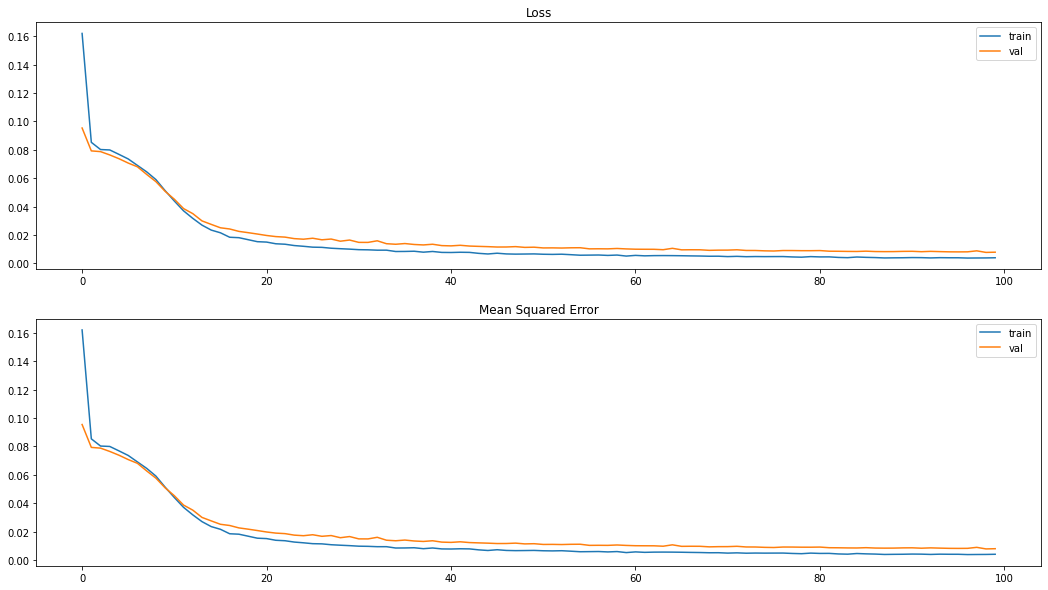

Total elapsed training time was: 3410.8069725037 seconds
Total elapsed training time was:  0.9474463812510172  hours


In [11]:
results_df = train_explore_model(exp_name= base_name+'_ifrelu_m2_multiopt', n_epochs=100, model_sel=2,
                                 in_dim_s = x_train.shape[1], in_act = 'relu', out_act = 'relu',
                                 x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_tst=x_tst, y_tst=y_tst)

In [12]:
results_df

exp_name exp_number optimizer b_s      lr  \
0   pe_e4_50a50b_ifrelu_m2_multiopt         16     nadam   4  0.0010   
1   pe_e4_50a50b_ifrelu_m2_multiopt         12    adamax   8  0.0010   
2   pe_e4_50a50b_ifrelu_m2_multiopt         18     nadam   8  0.0010   
3   pe_e4_50a50b_ifrelu_m2_multiopt          6      adam   8  0.0010   
4   pe_e4_50a50b_ifrelu_m2_multiopt         10    adamax   4  0.0010   
5   pe_e4_50a50b_ifrelu_m2_multiopt          4      adam   4  0.0010   
6   pe_e4_50a50b_ifrelu_m2_multiopt         17     nadam   4  0.0001   
7   pe_e4_50a50b_ifrelu_m2_multiopt         15     nadam   2  0.0001   
8   pe_e4_50a50b_ifrelu_m2_multiopt          5      adam   4  0.0001   
9   pe_e4_50a50b_ifrelu_m2_multiopt          2      adam   2  0.0010   
10  pe_e4_50a50b_ifrelu_m2_multiopt          8    adamax   2  0.0010   
11  pe_e4_50a50b_ifrelu_m2_multiopt          3      adam   2  0.0001   
12  pe_e4_50a50b_ifrelu_m2_multiopt         14     nadam   2  0.0010   
13  pe_e4_50a50b_ifrelu_m2_multiopt          7      adam   8  0.0001   
14  pe_e4_50a50b_ifrelu_m2_multiopt         19     nadam   8  0.0001   
15  pe_e4_50a50b_ifrelu_m2_multiopt         11    adamax   4  0.0001   
16  pe_e4_50a50b_ifrelu_m2_multiopt          9    adamax   2  0.0001   
17  pe_e4_50a50b_ifrelu_m2_multiopt         13    adamax   8  0.0001   

    trn_loss   trn_mse  val_loss   val_mse   tst_mse  
0   0.002147  0.002147  0.007112  0.007112  0.004738  
1   0.002684  0.002684  0.007118  0.007118  0.005121  
2   0.002405  0.002405  0.006811  0.006811  0.005233  
3   0.002378  0.002378  0.006664  0.006664  0.005698  
4   0.002698  0.002698  0.007190  0.007190  0.005774  
5   0.002565  0.002565  0.007220  0.007220  0.006049  
6   0.003173  0.003173  0.006403  0.006403  0.006174  
7   0.003002  0.003002  0.007310  0.007310  0.006262  
8   0.003491  0.003491  0.008543  0.008543  0.006324  
9   0.002433  0.002433  0.007526  0.007526  0.006514  
10  0.002334  0.002334  0.006491  0.006491  0.006748  
11  0.002541  0.002541  0.006170  0.006170  0.006869  
12  0.002753  0.002753  0.008176  0.008176  0.007264  
13  0.004324  0.004324  0.010034  0.010034  0.008884  
14  0.003801  0.003801  0.008183  0.008183  0.009186  
15  0.009699  0.009699  0.017761  0.017761  0.013014  
16  0.010211  0.010211  0.016989  0.016989  0.016593  
17  0.010126  0.010126  0.018894  0.018894  0.019005